In [1]:
import os
import glob
import itertools
import json
import importlib
import cv2
import sys

import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import statsmodels.api as sm
import tifffile as tf

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.retinotopy.utils as retutils
import analyze2p.extraction.rois as roiutils

import analyze2p.correlations as cr

In [4]:
%matplotlib notebook

# Plotting

In [5]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)

#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

# Source

In [6]:
experiment = 'gratings'
responsive_test='ROC'
# ---------------------------------------------------------------
response_type='dff'
responsive_thr=0.05 if responsive_test=='ROC' else 10.0
n_stds=2.5
n_bootstrap_iters=500
n_resamples=20
print(responsive_test, responsive_thr)

#### Responsive params
ori_fit_desc = gutils.get_fit_desc(response_type=response_type, 
                            responsive_test=responsive_test, 
                            n_stds=n_stds, responsive_thr=responsive_thr, 
                            n_bootstrap_iters=n_bootstrap_iters) #, 
#                             n_resamples=n_resamples)
data_id = '|'.join([traceid, ori_fit_desc])
print(data_id)

ROC 0.05
traces001|fit-dff_responsive-ROC-thr0.05_boot-500


# Output dir

In [7]:
dst_dir = os.path.join(aggregate_dir, 'correlations', 
                       'gratings_%s_%s' % (response_type, responsive_test))
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC


In [8]:
#### Set current output dir
curr_dst_dir = os.path.join(dst_dir, 'pref_theta')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta


# Load metadata

In [9]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
# cells, missing_seg = aggr.get_cells_by_area(sdata, return_missing=True)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()

all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in all_dkeys])
print(CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates()['visual_area'].value_counts().to_markdown())


/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
|    |   visual_area |
|:---|--------------:|
| Li |            16 |
| Lm |            10 |
| V1 |             9 |


# Load all fits

In [10]:
importlib.reload(gutils)

<module 'analyze2p.gratings.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/gratings/utils.py'>

In [11]:
gdata, missing_ = gutils.aggregate_ori_fits(CELLS, traceid=traceid, create_new=False,
                            fit_desc=ori_fit_desc, return_missing=True) 
gdata = hutils.split_datakey(gdata)
gdata['tf'] = gdata['sf']*gdata['speed'] # fit params
# Assign "preferred theta" for tested values
tested_thetas = np.arange(0, 360, 45)
theta_vals = np.arange(0, 360+45, 45)
gdata['tested_theta'] = [theta_vals[np.where(np.abs(t-theta_vals)==np.min(np.abs(t-theta_vals)))[0][0]] % 360. \
                            for t in gdata['theta_pref']]
gdata['tested_theta'] = gdata['tested_theta'].astype(float)

In [15]:
print("Filter by combined R2:")
print(gdata[gdata['r2comb']>0.5][['visual_area', 'datakey', 'cell']]\
    .drop_duplicates()['visual_area'].value_counts().to_markdown())
print("Filter by Goodness-of-Fit thr:")
print(gdata[gdata['gof']>0.5][['visual_area', 'datakey', 'cell']]\
    .drop_duplicates()['visual_area'].value_counts().to_markdown())

Filter by combined R2:
|    |   visual_area |
|:---|--------------:|
| V1 |           667 |
| Lm |           318 |
| Li |           209 |
Filter by Goodness-of-Fit thr:
|    |   visual_area |
|:---|--------------:|
| V1 |           443 |
| Lm |           227 |
| Li |            98 |


In [16]:
best_gof_ixs = gdata.groupby(['visual_area', 'datakey', 'cell'])['gof']\
                    .transform(max) == gdata['gof']
assert gdata.loc[best_gof_ixs].groupby(['visual_area', 'datakey', 'cell'])\
                    .count().max().max()==1
bestg = gdata.loc[best_gof_ixs].copy()
bestg.groupby(['visual_area']).count()

,response_pref,response_null,theta_pref,sigma,response_offset,asi,dsi,circvar_asi,circvar_dsi,r2,...,gof,sf,size,speed,datakey,animalid,fov,session,tf,tested_theta
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,349,349,349,349,349,349,349,349,349,349,...,349,349,349,349,349,349,349,349,349,349
Lm,422,422,422,422,422,422,422,422,422,422,...,422,422,422,422,422,422,422,422,422,422
V1,861,861,861,861,861,861,861,861,861,861,...,861,861,861,861,861,861,861,861,861,861


In [17]:
# Unique datasets, get dsets with most ncells pass
min_ncells=0
gof_thr=0.5
drop_repeats=True
counts = aggr.count_n_cells(bestg[bestg['gof']>gof_thr], 
                            name='n_cells', reset_index=True)

In [18]:
u_dkeys = aggr.drop_repeats(counts, colname='n_cells')   
FITS = pd.concat([g for (va, dk), g in bestg.groupby(['visual_area', 'datakey'])\
          if (va, dk) in u_dkeys])
print(FITS[['visual_area', 'datakey', 'cell']].drop_duplicates()\
            .groupby(['visual_area']).count())

             datakey  cell
visual_area               
Li               249   249
Lm               411   411
V1               861   861


# Get RF fits

In [19]:
importlib.reload(rfutils)

<module 'analyze2p.receptive_fields.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/receptive_fields/utils.py'>

In [19]:
# Load RF data
response_type='dff'
do_spherical_correction=True
# ---------------------------------------------------------------------
rfdf = rfutils.aggregate_fits(CELLS, sdata, response_type=response_type,
                       do_spherical_correction=do_spherical_correction)
print(rfdf['experiment'].unique())
rfdf['rf_theta_deg'] = [np.rad2deg(i) % 180 for i in rfdf['theta_Mm_c'].values]
rfdf = aggr.add_roi_positions(rfdf.copy())
# print stuff
rf_counts = aggr.count_n_cells(rfdf)
rf_counts.groupby('visual_area').sum()

N dpaths: 62, N unfit: 0
N datasets included: 67, N sessions excluded: 4
['average_rfs']


,n_cells
visual_area,
Li,430
Lm,228
V1,683


In [20]:
pass_gof=True
if pass_gof:
    gfits = bestg[bestg['gof']>0.5].copy()
else:
    gfits = bestg.copy()
gof_str = 'gof%.2f' % gof_thr if pass_gof else 'allfit'

In [21]:
importlib.reload(aggr)

<module 'analyze2p.aggregate_datasets' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py'>

In [22]:
# Combine Gratings FITS and RF fits
GRFS, grat_and_rf_counts = aggr.merge_cell_metrics_with_rfs(gfits, rfdf, 
                                                            split_suffix='rfs')

| visual_area   |   n_cells_all |   n_cells_rfs |
|:--------------|--------------:|--------------:|
| Li            |           491 |            37 |
| Lm            |           395 |            60 |
| V1            |           916 |           210 |


In [23]:
# Drop repeats
grat_and_rf_ukeys = aggr.drop_repeats(grat_and_rf_counts, colname='n_cells_all')
finaldf = pd.concat([g for (va, dk), g in GRFS.groupby(['visual_area', 'datakey'])
                  if (va, dk) in grat_and_rf_ukeys])
final_counts = aggr.count_n_cells(finaldf, split_suffix='rfs', split_na=True)
final_counts.groupby('visual_area').sum()

,n_cells_all,n_cells_rfs
visual_area,,
Li,338,24.0
Lm,373,57.0
V1,911,210.0


In [24]:
finaldf['eccentricity'].shape, finaldf['eccentricity'].dropna().shape

((1622,), (1181,))

In [25]:
# x = np.linspace(0, 315, 8)
# testdf = pd.DataFrame(list(itertools.combinations(x, 2)), columns=['x', 'y'])
# testdf['diff'] = [smallest_signed_angle(a, b) for a, b in testdf.values]

<IPython.core.display.Javascript object>


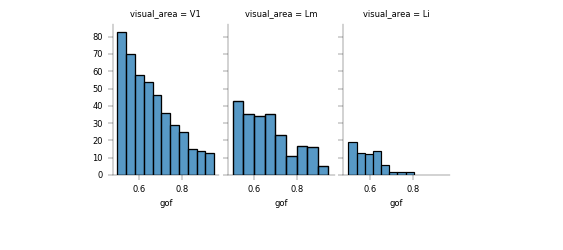

In [26]:
%matplotlib notebook
fg = sns.FacetGrid(data=finaldf, col='visual_area', col_order=visual_areas,
                   height=2.5, aspect=0.75)
fg.map(sns.histplot, 'gof')
pl.subplots_adjust(bottom=0.3, right=0.8, left=0.2)

In [27]:
x0_lim = 20
y0_lim = 20
ctr_df = finaldf[(finaldf['x0']<=x0_lim) & (finaldf['x0']>=-x0_lim) 
          & (finaldf['y0']<=y0_lim) & (finaldf['y0']>=-y0_lim)].copy()

In [28]:
ctr_counts = aggr.count_n_cells(ctr_df, split_na=True, split_suffix='rfs')
ctr_counts.groupby('visual_area').sum()

,n_cells_all,n_cells_rfs
visual_area,,
Li,172,9.0
Lm,95,25.0
V1,245,88.0


<IPython.core.display.Javascript object>


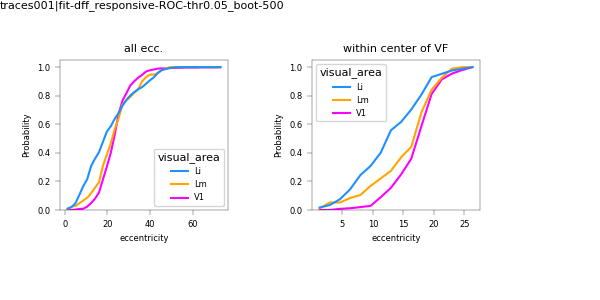

In [29]:
%matplotlib notebook
fig, axn = pl.subplots(1,2, figsize=(6,3))
sns.histplot(x='eccentricity', data=finaldf, ax=axn[0],
             hue='visual_area', palette=area_colors, fill=False,element='poly',
             stat='probability', common_norm=False, cumulative=True)
axn[0].set_title('all ecc.')
sns.histplot(x='eccentricity', data=ctr_df, ax=axn[1],
             hue='visual_area', palette=area_colors,fill=False, element='poly',
             stat='probability', common_norm=False, cumulative=True)
axn[1].set_title('within center of VF')
pplot.adjust_subplots(wide=False, left=0.1, bottom=0.3, right=0.8)
pplot.label_figure(fig, data_id)


In [174]:
# va='V1'
# dk='20191006_JC110_fov1'
# df_ = finaldf[(finaldf.visual_area==va) & (finaldf.datakey==dk)]
# df_.shape

(103, 58)

# Aggregate

In [32]:
finaldf[finaldf['gof']>0.5].groupby('visual_area').count()

,response_pref,response_null,theta_pref,sigma,response_offset,asi,dsi,circvar_asi,circvar_dsi,r2_x,...,rf_theta_deg,animalid_y,fov_y,session_y,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,70,70,70,70,70,70,70,70,70,70,...,24,24,24,24,24,24,24,24,24,24
Lm,219,219,219,219,219,219,219,219,219,219,...,57,57,57,57,57,57,57,57,57,57
V1,443,443,443,443,443,443,443,443,443,443,...,210,210,210,210,210,210,210,210,210,210


In [33]:
min_ncells=5
angdists = cr.aggregate_angular_dists(finaldf[finaldf['gof']>0.5], min_ncells=5)

too few cells: Li, 20190314_JC070_fov1
too few cells: Li, 20190315_JC070_fov2
too few cells: Li, 20190321_JC070_fov2
too few cells: Li, 20190522_JC089_fov1
too few cells: Li, 20190617_JC099_fov1
too few cells: Li, 20191105_JC117_fov1
too few cells: Li, 20191111_JC120_fov1
too few cells: Lm, 20191105_JC117_fov1


In [34]:
angdists.groupby(['visual_area']).count()

,neuron_pair,cell_1,cell_2,pref_dir_diff,pref_dir_diff_abs,pref_ori_diff,pref_ori_diff_abs,rf_angle_diff,rf_angle_diff_abs,response_pref,rf_distance,max_ecc,min_ecc,cortical_distance,datakey,n_cells
visual_area,,,,,,,,,,,,,,,,
Li,422,422,422,422,422,422,422,77,77,422,77,77,77,77,422,422
Lm,4377,4377,4377,4377,4377,4377,4377,329,329,4377,329,329,329,329,4377,4377
V1,14610,14610,14610,14610,14610,14610,14610,3255,3255,14610,3255,3255,3255,3255,14610,14610


<IPython.core.display.Javascript object>


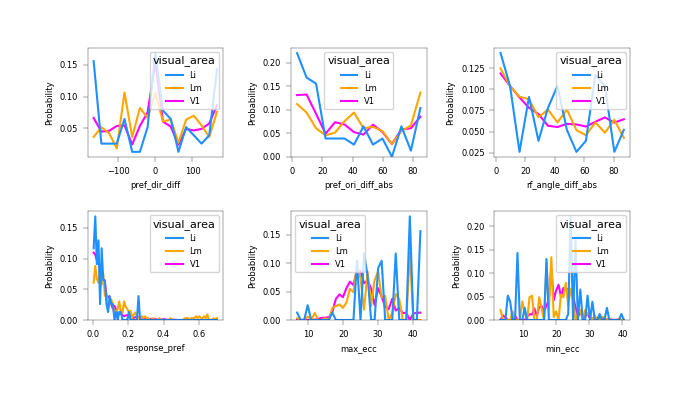

In [35]:
%matplotlib notebook
# plotd = angdists.copy()
plotd = angdists.dropna().copy()
plot_list = ['pref_dir_diff', 'pref_ori_diff_abs', 'rf_angle_diff_abs',
             'response_pref', 'max_ecc', 'min_ecc']
fig, axn =pl.subplots(2, int(len(plot_list)/2), figsize=(7,4))
for ax, par in zip(axn.flat, plot_list):
    sns.histplot(x=par, data=plotd, ax=ax, common_norm=False,
            hue='visual_area', palette=area_colors, stat='probability',
            element='poly', fill=False)
pl.subplots_adjust(bottom=0.2, wspace=0.5, hspace=0.5)

In [36]:
scatter_kws={'s':2}
ctx_limits = {'near': {'upper_lim': 50, 'lower_lim': None},
              'intermediate': {'upper_lim': 250, 'lower_lim': 100},
              'far': {'upper_lim': None, 'lower_lim': 300}}

<IPython.core.display.Javascript object>


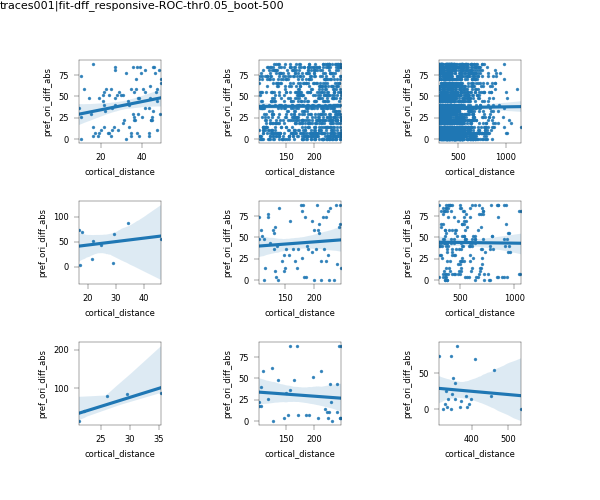

In [38]:
%matplotlib notebook
y_var='pref_ori_diff_abs'
dist_var = 'cortical_distance'
with_rfs=False
# --------------------------------------------------------------
plotd = angdists.dropna().copy() if with_rfs else angdists.copy()
plot_str = 'withrfs' if with_rfs else 'all'

# plot
fig, axn = pl.subplots(3, 3, figsize=(6,5))
for va, vg in plotd.groupby('visual_area'):
    vi = visual_areas.index(va)
    for di, dist_cond in enumerate(['near', 'intermediate', 'far']):
        ax = axn[vi, di]
        df_ = cr.get_bins_within_limits(vg, bin_name=dist_var, 
                                    upper_lim=ctx_limits[dist_cond]['upper_lim'],
                                    lower_lim=ctx_limits[dist_cond]['lower_lim'])
        g0 = sns.regplot(data=df_, ax=ax, scatter=True,
                    x=dist_var, y=y_var, scatter_kws=scatter_kws)
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, wspace=0.5, hspace=0.7)
pplot.label_figure(fig, data_id)

figname = '%s_v_CTX_near-mid-far_%s' % (y_var, plot_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [40]:
import pingouin as pg

In [42]:
# plotd = angdists.copy() #.dropna().copy()
#vg = plotd[plotd.visual_area=='V1']
s_=[]
for va, vg in angdists.groupby('visual_area'):
    for di, dist_cond in enumerate(['near', 'intermediate', 'far']):
        df_ = cr.get_bins_within_limits(vg, bin_name=dist_var, 
                                upper_lim=ctx_limits[dist_cond]['upper_lim'],
                                lower_lim=ctx_limits[dist_cond]['lower_lim'])
        v1 = df_['cortical_distance'].values
        v2 = df_[y_var].values
        curr_stat = pg.mwu(v1, v2)
        curr_stat['distance_cond'] = dist_cond
        curr_stat['visual_area'] = va
        curr_stat['with_rfs'] = with_rfs
        s_.append(curr_stat)
statsdf = pd.concat(s_, axis=0)
statsdf

,U-val,tail,p-val,RBC,CLES,distance_cond,visual_area,with_rfs
MWU,5.0,two-sided,1.436721e-01,0.600000,0.200000,near,Li,False
MWU,1296.0,two-sided,3.021244e-13,-1.000000,1.000000,intermediate,Li,False
MWU,529.0,two-sided,6.566437e-09,-1.000000,1.000000,far,Li,False
MWU,31.0,two-sided,1.619724e-01,0.380000,0.310000,near,Lm,False
MWU,4225.0,two-sided,7.943467e-23,-1.000000,1.000000,intermediate,Lm,False
MWU,40804.0,two-sided,1.058006e-67,-1.000000,1.000000,far,Lm,False
MWU,3411.0,two-sided,4.021877e-02,0.176186,0.411907,near,V1,False
MWU,697225.0,two-sided,3.310754e-274,-1.000000,1.000000,intermediate,V1,False
MWU,3389281.0,two-sided,0.000000e+00,-1.000000,1.000000,far,V1,False


In [75]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [190]:
# Check parameter ranges
# metric_list = ['pref_dir_diff', 'pref_dir_diff_abs', 
#                'pref_ori_diff', 'pref_ori_diff_abs', 
#                'rf_angle_diff', 'rf_angle_diff_abs', 
#                 'rf_distance', 'cortical_distance', 'max_ecc', 'min_ecc']
# fig, axn = pl.subplots(2, int(len(metric_list)/2), figsize=(8,5))
# for ax, p in zip(axn.flat, metric_list):
#     sns.histplot(angdists[p], ax=ax)
#     ax.set_title(p, loc='left', fontsize=8)
#     ax.set_xlabel('')
# pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, wspace=0.5, hspace=0.5, top=0.8)
# fig.text(0.01, 0.9, 'Value ranges for PW calculations', fontsize=8)

In [88]:
# Bin data
bin_lut = {'pref_ori_diff_abs': np.linspace(0, 90, 4), #7), #7),
           'pref_dir_diff_abs': np.linspace(0, 180, 7), #7),
           'rf_angle_diff_abs': np.arange(0, 90, 20),
           'cortical_distance': np.arange(0, 1000, 20),
           'rf_distance': np.arange(0, 50, 2.5),
           'min_ecc': np.arange(0, 40, 5),
           'max_ecc': np.arange(0, 50, 10) 
}

<IPython.core.display.Javascript object>


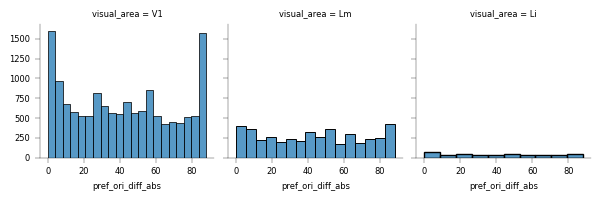

In [44]:
fg = sns.FacetGrid(data=angdists, col='visual_area', col_order=visual_areas,
                  height=2)
fg.map(sns.histplot, 'pref_ori_diff_abs')

In [45]:
angdists.groupby(['visual_area']).count()

,neuron_pair,cell_1,cell_2,pref_dir_diff,pref_dir_diff_abs,pref_ori_diff,pref_ori_diff_abs,rf_angle_diff,rf_angle_diff_abs,response_pref,rf_distance,max_ecc,min_ecc,cortical_distance,datakey,n_cells
visual_area,,,,,,,,,,,,,,,,
Li,422,422,422,422,422,422,422,77,77,422,77,77,77,77,422,422
Lm,4377,4377,4377,4377,4377,4377,4377,329,329,4377,329,329,329,329,4377,4377
V1,14610,14610,14610,14610,14610,14610,14610,3255,3255,14610,3255,3255,3255,3255,14610,14610


In [77]:
hue_label = 'pref_ori_diff_abs'
hue_bins = bin_lut[hue_label]
angdists['binned_%s' % hue_label] = pd.cut(angdists[hue_label], \
                                                hue_bins, 
                                                labels=hue_bins[0:-1])

angdists.groupby(['visual_area', 'binned_%s' % hue_label]).count()

neuron_pair  cell_1  cell_2  \
visual_area binned_pref_ori_diff_abs                                
Li          0.0                               162     162     162   
            30.0                              127     127     127   
            60.0                              117     117     117   
Lm          0.0                              1400    1400    1400   
            30.0                             1416    1416    1416   
            60.0                             1390    1390    1390   
V1          0.0                              5178    5178    5178   
            30.0                             4386    4386    4386   
            60.0                             4399    4399    4399   

                                      pref_dir_diff  pref_dir_diff_abs  \
visual_area binned_pref_ori_diff_abs                                     
Li          0.0                                 162                162   
            30.0                                127                127   
            60.0                                117                117   
Lm          0.0                                1400               1400   
            30.0                               1416               1416   
            60.0                               1390               1390   
V1          0.0                                5178               5178   
            30.0                               4386               4386   
            60.0                               4399               4399   

                                      pref_ori_diff  pref_ori_diff_abs  \
visual_area binned_pref_ori_diff_abs                                     
Li          0.0                                 162                162   
            30.0                                127                127   
            60.0                                117                117   
Lm          0.0                                1400               1400   
            30.0                               1416               1416   
            60.0                               1390               1390   
V1          0.0                                5178               5178   
            30.0                               4386               4386   
            60.0                               4399               4399   

                                      rf_angle_diff  rf_angle_diff_abs  \
visual_area binned_pref_ori_diff_abs                                     
Li          0.0                                  43                 43   
            30.0                                 14                 14   
            60.0                                 15                 15   
Lm          0.0                                 104                104   
            30.0                                109                109   
            60.0                                100                100   
V1          0.0                                1353               1353   
            30.0                                843                843   
            60.0                                854                854   

                                      response_pref  rf_distance  max_ecc  \
visual_area binned_pref_ori_diff_abs                                        
Li          0.0                                 162           43       43   
            30.0                                127           14       14   
            60.0                                117           15       15   
Lm          0.0                                1400          104      104   
            30.0                               1416          109      109   
            60.0                               1390          100      100   
V1          0.0                                5178         1353     1353   
            30.0                               4386          843      843   
            60.0                               4399          85

<IPython.core.display.Javascript object>


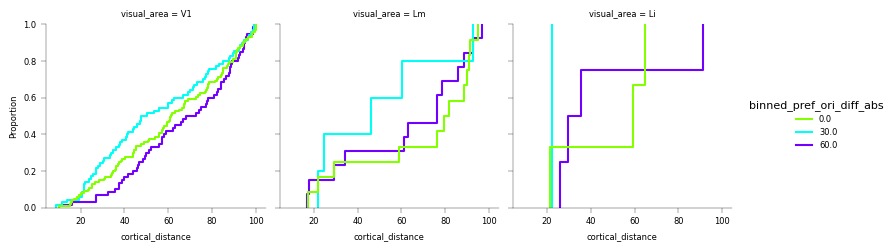

In [78]:
cmap='hsv'
plotd = angdists[angdists.cortical_distance<=100]
fg = sns.displot(data=plotd, col='visual_area', col_order=visual_areas,
           x=dist_var, height=2.5,
           hue='binned_%s' % hue_label, palette=cmap, kind='ecdf')

# Only look at MOST fit cells 

In [230]:
min_ncells=5
curr_gof=0.66
fitdists = cr.aggregate_angular_dists(finaldf[finaldf['gof']>=curr_gof], min_ncells=5)

too few cells: Li, 20190315_JC070_fov2
too few cells: Li, 20190602_JC091_fov1
too few cells: Li, 20190609_JC099_fov1
too few cells: Li, 20190614_JC091_fov1
too few cells: Li, 20191018_JC113_fov1
too few cells: Lm, 20190306_JC061_fov2
too few cells: V1, 20190512_JC083_fov1


In [521]:
fitdists.groupby('visual_area').count()

,neuron_pair,cell_1,cell_2,pref_dir_diff,pref_dir_diff_abs,pref_ori_diff,pref_ori_diff_abs,rf_angle_diff,rf_angle_diff_abs,response_pref,rf_distance,max_ecc,min_ecc,cortical_distance,datakey,n_cells
visual_area,,,,,,,,,,,,,,,,
Lm,1062,1062,1062,1062,1062,1062,1062,81,81,1062,81,81,81,81,1062,1062
V1,2522,2522,2522,2522,2522,2522,2522,574,574,2522,574,574,574,574,2522,2522


In [522]:
currdf = fitdists[fitdists.visual_area.isin(['V1', 'Lm'])].copy()

step=20
ctx_dist_bins = np.arange(0, 1000+step, step)
currdf['binned_cortical_distance'] = pd.cut(currdf['cortical_distance'], \
                                                ctx_dist_bins, include_lowest=True,
                                                labels=ctx_dist_bins[0:-1])
currdf['binned_cortical_distance_label'] = [int(d) if not np.isnan(d) else d \
                                for d in currdf['binned_cortical_distance'].values]
step=100
dist_bins = np.arange(0, 1000+step, step)
currdf['distance_type'] = pd.cut(currdf['cortical_distance'], \
                                                dist_bins, include_lowest=True,
                                                labels=dist_bins[0:-1])
currdf['distance_label'] = [int(d) if not np.isnan(d) else d \
                             for d in currdf['distance_type'].values]


<IPython.core.display.Javascript object>


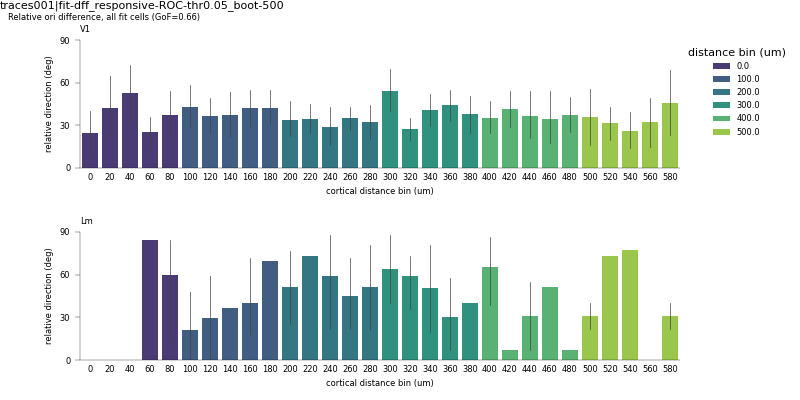

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:648: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC relative_ori_by_hue_distbin_BESTFIT


In [526]:
stim_str='ori'
y_var = 'pref_%s_diff_abs' % stim_str 
hue_label = 'distance_label'
x_var='binned_cortical_distance_label'
palette='viridis'
ylim = (0, 90) if stim_str=='ori' else (0, 180)
# Ticks
min_npairs=0 #10
max_dist = 600
sorted_x_vars = [k for k, v in currdf.groupby(x_var) if k<max_dist]
# Colors
vals_ = dist_bins[dist_bins<=max_dist][0:-1] #np.arange(0, 800+100, 100)
cols_ = sns.color_palette('viridis', n_colors=len(vals_))
dist_colors = dict((k, v) for k, v in zip(vals_, cols_))
plotd = currdf[(currdf.cortical_distance<=max_dist)].copy()

# plot
fg = sns.FacetGrid(data=plotd, row='visual_area', row_order=['V1', 'Lm'],
                   height=2, aspect=4, sharex=False, sharey=False)
fg.map(sns.barplot, x_var, y_var, hue_label, palette=dist_colors,
      dodge=False, errwidth=0.5, order=sorted_x_vars)
#[pl.setp(ax.texts, text="") for ax in fg.axes.flat] 
fg.set_titles("{row_name}", loc='left')  # use this argument literally

for ax in fg.axes.flat:
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('cortical distance bin (um)')
    #ax.set_xticks(np.arange(0, len(sorted_x_vars)))
    ax.set_xticklabels([int(i) for i in sorted_x_vars])
    ax.set_ylim(ylim)
    ax.set_yticks(np.linspace(0, ylim[-1], 4))
    ax.set_ylabel('relative direction (deg)')
    ax.set_title('')

ax=fg.axes.flat[0]
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False, 
         title='distance bin (um)')
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.1, top=0.9, wspace=0.5, hspace=0.5)

fg.fig.text(0.01, 0.95, 'Relative %s difference, all fit cells (GoF=%.2f)' \
         % (stim_str, curr_gof))

pplot.label_figure(fg.fig, data_id)

figname = 'relative_%s_by_hue_distbin_BESTFIT' % stim_str
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

## Split by DSI vs. ASI vs. Neither

In [527]:
finaldf.groupby('visual_area').count()

,response_pref,response_null,theta_pref,sigma,response_offset,asi,dsi,circvar_asi,circvar_dsi,r2_x,...,rf_theta_deg,animalid_y,fov_y,session_y,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,70,70,70,70,70,70,70,70,70,70,...,292,292,292,292,292,292,292,292,292,292
Lm,219,219,219,219,219,219,219,219,219,219,...,211,211,211,211,211,211,211,211,211,211
V1,443,443,443,443,443,443,443,443,443,443,...,678,678,678,678,678,678,678,678,678,678


<IPython.core.display.Javascript object>


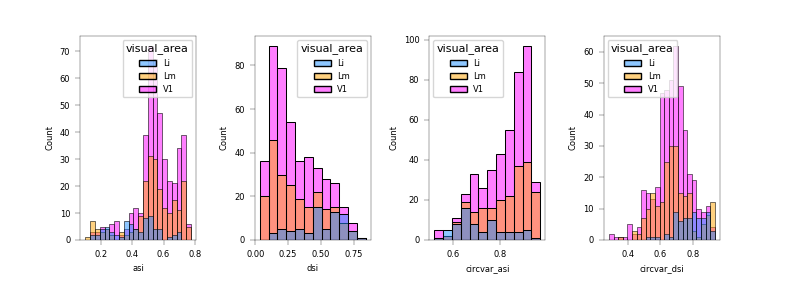

In [528]:
plot_params = ['asi', 'dsi', 'circvar_asi', 'circvar_dsi']
fig, axn = pl.subplots(1, len(plot_params), figsize=(8,3))
for ax, par in zip(axn.flat, plot_params):
    sns.histplot(x=par, data=finaldf, hue='visual_area', palette=area_colors, ax=ax,
                common_norm=False)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, wspace=0.5)

# Most selective cells only

In [535]:
min_ncells=2
asi_lim=0.2
dsi_lim=0.2

gof=0.05
dsi_df = finaldf[(finaldf.dsi>=dsi_lim) & (finaldf.gof>=gof)].copy()
asi_df = finaldf[(finaldf.asi>=asi_lim) & (finaldf.gof>=gof)].copy()

# asi_lim=0.6
# dsi_lim=0.8
# dsi_df = finaldf[(finaldf.circvar_dsi>=dsi_lim) & (finaldf.gof>=0.5)].copy()
# asi_df = finaldf[(finaldf.circvar_asi>=asi_lim) & (finaldf.gof>=0.5)].copy()
asi_df.groupby(['visual_area']).count()

,response_pref,response_null,theta_pref,sigma,response_offset,asi,dsi,circvar_asi,circvar_dsi,r2_x,...,rf_theta_deg,animalid_y,fov_y,session_y,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,64,64,64,64,64,64,64,64,64,64,...,22,22,22,22,22,22,22,22,22,22
Lm,206,206,206,206,206,206,206,206,206,206,...,54,54,54,54,54,54,54,54,54,54
V1,435,435,435,435,435,435,435,435,435,435,...,206,206,206,206,206,206,206,206,206,206


In [536]:
asi_diffs = cr.aggregate_angular_dists(asi_df, min_ncells=2)
dsi_diffs = cr.aggregate_angular_dists(dsi_df, min_ncells=2)

too few cells: Li, 20190314_JC070_fov1
too few cells: Li, 20190315_JC070_fov2
too few cells: Li, 20190321_JC070_fov2
too few cells: Lm, 20191105_JC117_fov1
too few cells: Li, 20190314_JC070_fov1
too few cells: Li, 20190315_JC070_fov2
too few cells: Li, 20190321_JC070_fov2
too few cells: Li, 20190617_JC099_fov1
too few cells: Lm, 20191105_JC117_fov1


In [543]:
dsi_diffs['selectivity'] = 'dir'
asi_diffs['selectivity'] = 'ori'
splitdf0 = pd.concat([dsi_diffs, asi_diffs], axis=0, ignore_index=True)

In [544]:
curr_areas = ['V1', 'Lm', 'Li']
splitdf = splitdf0[(splitdf0.visual_area.isin(curr_areas))].dropna().copy()

ctx_dist_bins = np.arange(0, 1000+50, 50)
splitdf['binned_cortical_distance'] = pd.cut(splitdf['cortical_distance'], \
                                                ctx_dist_bins, include_lowest=True,
                                                labels=ctx_dist_bins[0:-1])
splitdf['binned_cortical_distance_label'] = [int(d) if not np.isnan(d) else d \
                                for d in splitdf['binned_cortical_distance'].values]
dist_bins = np.arange(0, 1000+100, 100)
splitdf['distance_type'] = pd.cut(splitdf['cortical_distance'], \
                                                dist_bins, include_lowest=True,
                                                labels=dist_bins[0:-1])
splitdf['distance_label'] = [int(d) if not np.isnan(d) else d \
                             for d in splitdf['distance_type'].values]


In [545]:
# Ticks
min_npairs=0 #10
max_dist = 600
sorted_x_vars = [k for k, v in currdf.groupby(x_var) if k<max_dist]
# Colors
vals_ = dist_bins[dist_bins<=max_dist][0:-1] #np.arange(0, 800+100, 100)
cols_ = sns.color_palette('viridis', n_colors=len(vals_))
dist_colors = dict((k, v) for k, v in zip(vals_, cols_))

<IPython.core.display.Javascript object>


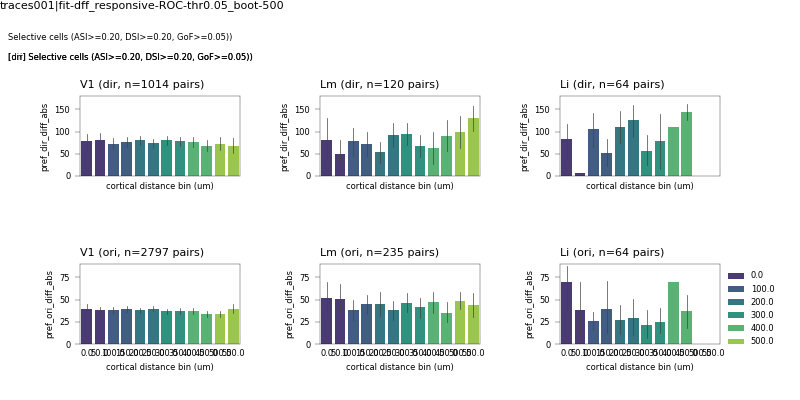

In [546]:
hue_label = 'pref_ori_diff_abs'
hue_bins = bin_lut[hue_label]
min_npairs=0 #10
x_var='binned_cortical_distance_label'

plotd = splitdf[(splitdf.cortical_distance<=max_dist)].copy()
fig, axn = pl.subplots(2,3, figsize=(8,4), sharex=True, sharey=False)
for va, vg in plotd.groupby('visual_area'):
    vi=visual_areas.index(va)
    for di, (stim_str, sg) in enumerate(vg.groupby('selectivity')):
        ax=axn[di, vi]
        # bins
        y_var = 'pref_%s_diff_abs' % stim_str
        ylim = (0, 90) if stim_str=='ori' else (0, 180)
        n_pairs = len(sg['neuron_pair'].unique())
        ax.set_title("%s (%s, n=%i pairs)" % (va, stim_str, n_pairs), loc='left')
        g = sns.barplot(x=x_var, y=y_var, data=sg, ax=ax, 
                    errwidth=0.5, hue='distance_label', palette=dist_colors,
                    zorder=-1000, dodge=False)
        ax.legend_.remove()
        ax.set_box_aspect(0.5)
        ax.set_ylim(ylim)
        ax.set_xlabel('cortical distance bin (um)')
        ax.tick_params(which='both', axis='x', size=0)
axn.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.8, wspace=0.5, hspace=0.5)
pplot.label_figure(fig, data_id)

fig.text(0.01, 0.9, 'Selective cells (ASI>=%.2f, DSI>=%.2f, GoF>=%.2f))'
        % (asi_lim, dsi_lim, gof))

figname='relative_diffs_hue_bindist_SELECTIVE'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [547]:
max_dist=800
step=100
np.arange(0, max_dist+step, step)

array([  0, 100, 200, 300, 400, 500, 600, 700, 800])

<IPython.core.display.Javascript object>


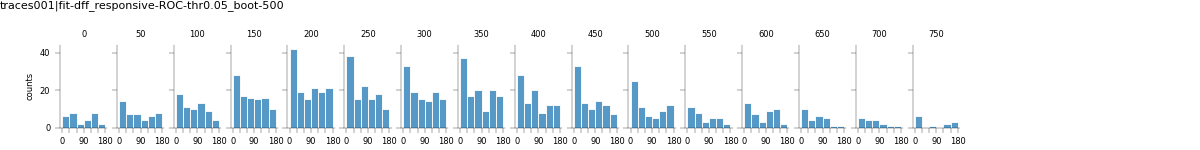

<IPython.core.display.Javascript object>


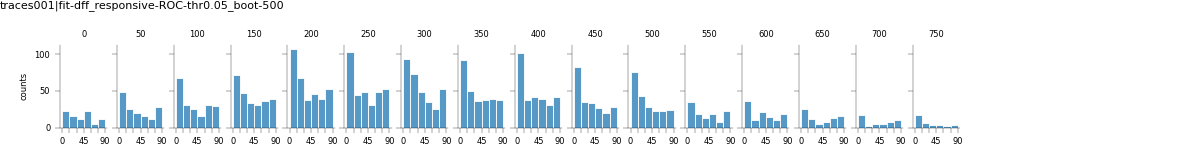

In [548]:
min_npairs=0 #10
palette='viridis'

max_dist=800
step=50
plot_bins = np.arange(0, max_dist+step, step)
splitdf['plot_bins'] = pd.cut(splitdf['cortical_distance'], plot_bins,
                             include_lowest=True, labels=plot_bins[0:-1])
plotd = splitdf[splitdf.visual_area=='V1']

for stim_str, sg in plotd.groupby('selectivity'):
    x_var = 'pref_%s_diff_abs' % stim_str
    max_val = 180 if stim_str=='dir' else 90
    step=30 if stim_str=='dir' else 15
    x_bins = np.arange(0, max_val+step, step)
    fg = sns.FacetGrid(col='plot_bins', data=sg,
                       height=1.5, aspect=0.5, sharey=True, sharex=False)
    fg.map(sns.histplot, x_var, bins=x_bins, edgecolor='w', stat='count')
    fg.set_titles("{col_name}")
    fg.axes[0, 0].set_ylabel('counts')
    fg.axes[0, 1].set_ylabel('counts')
    for ax in fg.axes.flat:
        ax.set_xticks(x_bins)
        ax.set_xticklabels([i if i in x_bins[0::3] else '' for i in x_bins])
    pl.subplots_adjust(left=0.05, right=0.8, bottom=0.15, top=0.7, 
                       wspace=0.2, hspace=0.5)

    fig.text(0.01, 0.85, '[%s] Selective cells (ASI>=%.2f, DSI>=%.2f, GoF>=%.2f))'
        % (stim_str, asi_lim, dsi_lim, gof))

    pplot.label_figure(fg.fig, data_id)
    figname = 'SELECTIVE_relative_%s_counts_by_dist' % stim_str
    pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [549]:
ctx_stepsize=25
ctx_maxdist=800
ctx_dist_bins = np.arange(0, ctx_maxdist+ctx_stepsize, ctx_stepsize) # steps of 25 um
splitdf_ = splitdf[(splitdf.visual_area=='V1') 
                 & (splitdf.cortical_distance<=ctx_maxdist)].copy()

splitdf_['binned_cortical_distance'] = pd.cut(splitdf_['cortical_distance'], \
                                                ctx_dist_bins,  include_lowest=True,
                                                labels=ctx_dist_bins[0:-1])
# Set colors
# Ticks
min_npairs=0 #10
max_dist = ctx_maxdist
sorted_x_vars = [k for k, v in currdf.groupby(x_var) if k<max_dist]
# Colors
vals_ = dist_bins[dist_bins<=max_dist][0:-1] #np.arange(0, 800+100, 100)
cols_ = sns.color_palette('viridis', n_colors=len(vals_))
dist_colors = dict((k, v) for k, v in zip(vals_, cols_))

<IPython.core.display.Javascript object>


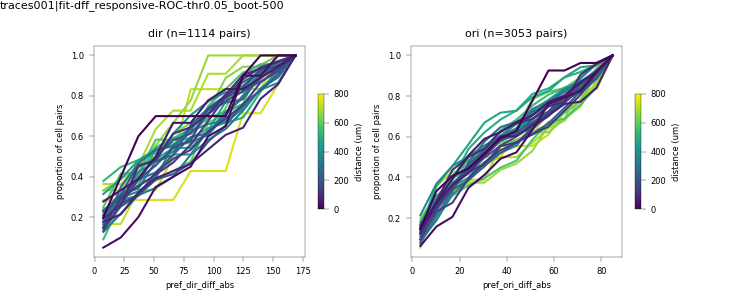

In [550]:
cmap = 'viridis'
min_npairs =0
hue_label = 'cortical_distance'
cbar_label = 'distance (um)' if hue_label=='cortical_distance' else None
# ------------------------------------------
stim_str = 'ori'
x_var = 'pref_%s_diff_abs' % stim_str
# --------------------------------------------
hue_bins = np.arange(0, ctx_maxdist, ctx_stepsize)

fig, axn = pl.subplots(1, 2, figsize=(7.5,3))
for ax, (stim_str, vg) in zip(axn.flat, splitdf_.groupby('selectivity')):
    df_ = cr.get_binned_X(vg, x_label=hue_label, x_bins=hue_bins, 
                         min_npairs=0, labels=hue_bins[0:-1])
    x_var = 'pref_%s_diff_abs' % stim_str
    g = sns.histplot(x=x_var, hue='binned_%s' % hue_label, data=df_, ax=ax,
            cumulative=True, fill=None, element='poly', stat='probability',
            common_norm=False, palette=cmap, hue_norm=(0, ctx_maxdist), 
            line_kws={'lw': 2, 'alpha': 0.5})
    ax.legend_.remove()
    ax.set_box_aspect(1); #ax.set_xlim([-1, 1]); ax.set_ylim([0, 1]);
    n_pairs = len(vg['neuron_pair'].unique())
    ax.set_title('%s (n=%i pairs)' % (stim_str, n_pairs))
    ax.set_ylabel('proportion of cell pairs');
    if not shared_colorbar:
        norm = pl.Normalize(0, ctx_maxdist)
        sm = pl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5, label=cbar_label)
# Colorbar
pplot.label_figure(fig, data_id)
figname = 'relative_diff_hue_distance_curves_V1'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [551]:
ctx_stepsize=25
ctx_maxdist=800
ctx_dist_bins = np.arange(0, ctx_maxdist+ctx_stepsize, ctx_stepsize) # steps of 25 um
splitdf_ = splitdf[(splitdf.visual_area=='V1') 
                 & (splitdf.cortical_distance<=ctx_maxdist)].copy()


ctx_dist_bins = np.arange(0, ctx_maxdist+ctx_stepsize, ctx_stepsize)
splitdf_['binned_cortical_distance'] = pd.cut(splitdf_['cortical_distance'], \
                                                ctx_dist_bins, include_lowest=True,
                                                labels=ctx_dist_bins[0:-1])
splitdf_['binned_cortical_distance_label'] = [int(d) if not np.isnan(d) else d \
                                for d in splitdf_['binned_cortical_distance'].values]
dist_bins = np.arange(0, ctx_maxdist+100, 100)
splitdf_['distance_type'] = pd.cut(splitdf_['cortical_distance'], \
                                                dist_bins, include_lowest=True,
                                                labels=dist_bins[0:-1])
splitdf_['distance_label'] = [int(d) if not np.isnan(d) else d \
                             for d in splitdf_['distance_type'].values]

<IPython.core.display.Javascript object>


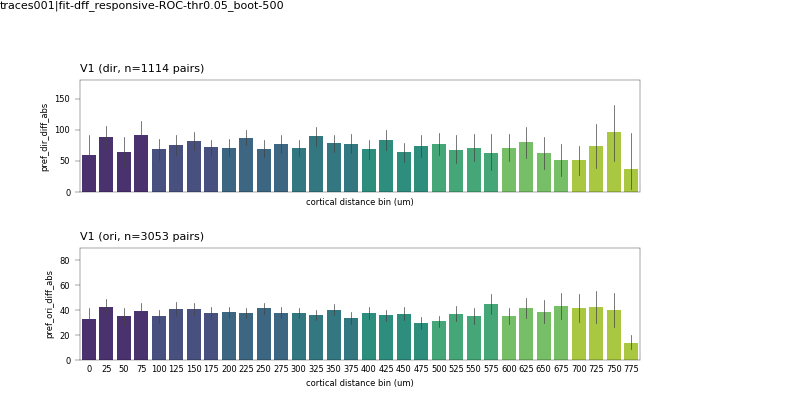

In [552]:
hue_label = 'pref_ori_diff_abs'
hue_bins = bin_lut[hue_label]
min_npairs=0 #10
x_var='binned_cortical_distance_label'

fig, axn = pl.subplots(2,1, figsize=(8,4), sharex=True, sharey=False)
for di, (stim_str, sg) in enumerate(splitdf_.groupby('selectivity')):
    ax=axn[di]
    y_var = 'pref_%s_diff_abs' % stim_str
    ylim = (0, 90) if stim_str=='ori' else (0, 180)
    n_pairs = len(sg['neuron_pair'].unique())
    ax.set_title("%s (%s, n=%i pairs)" % (va, stim_str, n_pairs), loc='left')
    ax.set_ylim(ylim)
    g = sns.barplot(x=x_var, y=y_var, data=sg, ax=ax, 
                errwidth=0.5, hue='distance_label', palette=dist_colors,
                zorder=-1000, dodge=False)
    ax.legend_.remove()
    ax.set_xlabel('cortical distance bin (um)')
    ax.tick_params(which='both', axis='x', size=0)

pl.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=0.8, wspace=0.5, hspace=0.5)


pplot.label_figure(fig, data_id)
figname = 'relative_diffs_avg_each_distbin' #counts_by_dist' % stim_str
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [212]:
ax.title


Text(0.5, 1.0, 'selectivity = asi | plot_bins = 200')

<IPython.core.display.Javascript object>


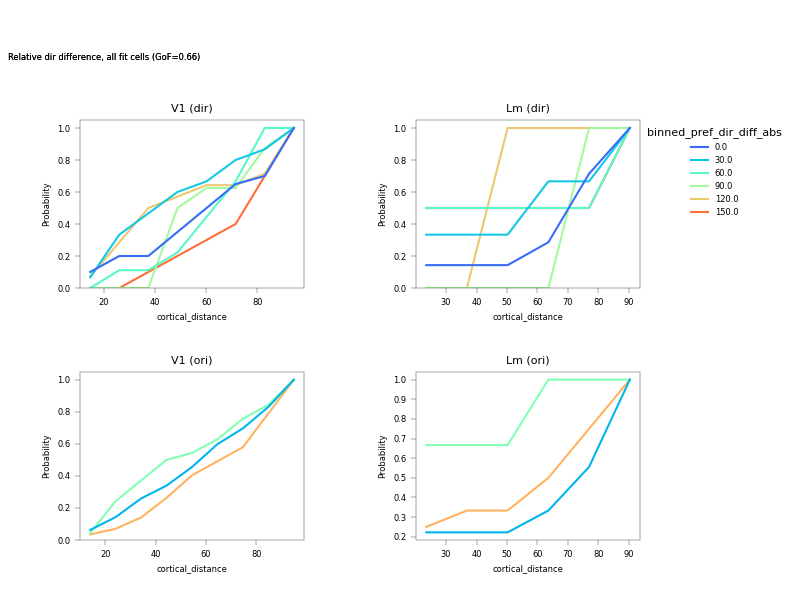

In [501]:

min_npairs=0 #10
x_var='cortical_distance'
cmap ='rainbow'

curr_areas = ['V1', 'Lm']
plotd = splitdf[(splitdf.cortical_distance<=100) & (splitdf.visual_area.isin(curr_areas))].copy()
fig, axn = pl.subplots(2,2, figsize=(8,6))
for va, vg in plotd.groupby('visual_area'):
    vi=visual_areas.index(va)
    for di, (stim_str, sg) in enumerate(vg.groupby('selectivity')):
        ax=axn[di, vi]
        ax.set_title("%s (%s)" % (va, stim_str))
        hue_label = 'pref_%s_diff_abs' % stim_str
        hue_bins = bin_lut[hue_label]
        df_ = cr.get_binned_X(sg, x_label=hue_label, x_bins=hue_bins, 
                         min_npairs=min_npairs, labels=hue_bins[0:-1])
        g = sns.histplot(x=x_var, hue='binned_%s' % hue_label, data=df_, ax=ax,
            cumulative=True, fill=None, element='poly', stat='probability',
            common_norm=False, palette=cmap, #hue_norm=(min_, max_), 
            line_kws={'lw': 2, 'alpha': 0.5})
        if vi==len(curr_areas)-1 and di==0:
            pplot.sns_histplot_legend(ax) #bbox_to_anchor=(1,1), loc='upper left', frameon=False)
        else:
            ax.legend_.remove()
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=0.8, wspace=0.5, hspace=0.5)

In [106]:
splitdf[splitdf.cortical_distance<=100].groupby(['selectivity', 'visual_area']).count()

neuron_pair  cell_1  cell_2  pref_dir_diff  \
selectivity visual_area                                               
asi         Lm                     6       6       6              6   
            V1                    46      46      46             46   
dsi         Lm                     2       2       2              2   
            V1                     9       9       9              9   

                         pref_dir_diff_abs  pref_ori_diff  pref_ori_diff_abs  \
selectivity visual_area                                                        
asi         Lm                           6              6                  6   
            V1                          46             46                 46   
dsi         Lm                           2              2                  2   
            V1                           9              9                  9   

                         rf_angle_diff  rf_angle_diff_abs  response_pref  \
selectivity visual_area                                                    
asi         Lm                       6                  6              6   
            V1                      46                 46             46   
dsi         Lm                       2                  2              2   
            V1                       9                  9              9   

                         rf_distance  max_ecc  min_ecc  cortical_distance  \
selectivity visual_area                                                     
asi         Lm                     6        6        6                  6   
            V1                    46       46       46                 46   
dsi         Lm                     2        2        2                  2   
            V1                     9        9        9                  9   

                         datakey  n_cells  
selectivity visual_area                    
asi         Lm                 6        6  
            V1                46       46  
dsi         Lm                 2        2  
            V1                 9        9

<IPython.core.display.Javascript object>


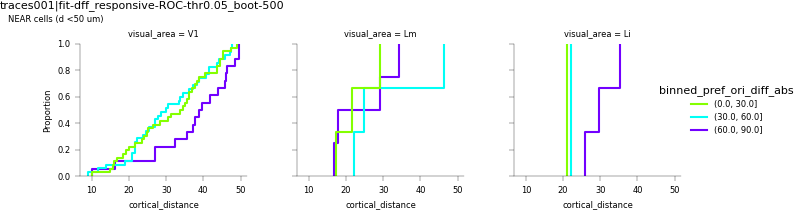

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta pref_ori_diff_abs__cortical_distance_NEAR


<IPython.core.display.Javascript object>


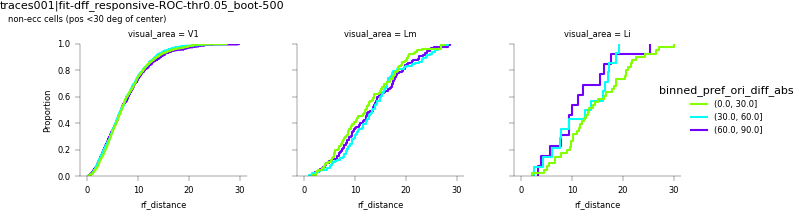

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta pref_ori_diff_abs__rf_distance_NEAR


In [960]:
hue_label = 'pref_ori_diff_abs'
# hue_label = 'rf_angle_diff_abs'
cmap='hsv'
currdf['binned_%s' % hue_label], bin_edges = pd.cut(currdf[hue_label], \
                                                bin_lut[hue_label], retbins=True)
plotd0 = currdf[currdf['max_ecc']<=np.inf]

upper_lim=50
plotd = plotd0[plotd0['cortical_distance']<=upper_lim].copy()
%matplotlib notebook
# ------------------------------------------------
x_var='cortical_distance'
fg = sns.displot(data=plotd, col='visual_area', col_order=visual_areas,
           x=x_var, height=2.2,
           hue='binned_%s' % hue_label, palette=cmap,
           kind='ecdf')
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, wspace=0.3, top=0.8)
fg.fig.text(0.01, 0.9, 'NEAR cells (d <%i um)' % upper_lim)

pplot.label_figure(fg.fig, data_id)
figname = '%s__%s_NEAR' % (hue_label, x_var)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)
# ------------------------------------------------
upper_lim=30
x_var='rf_distance'
plotd = plotd0[plotd0['rf_distance']<upper_lim].copy()
fg = sns.displot(data=plotd, col='visual_area', col_order=visual_areas,
           x=x_var, height=2.2,
           hue='binned_%s' % hue_label, palette=cmap, kind='ecdf')
fg.fig.text(0.01, 0.9, 'non-ecc cells (pos <%i deg of center)' % upper_lim)

pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, wspace=0.3, top=0.8)
pplot.label_figure(fg.fig, data_id)
figname = '%s__%s_NEAR' % (hue_label, x_var)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


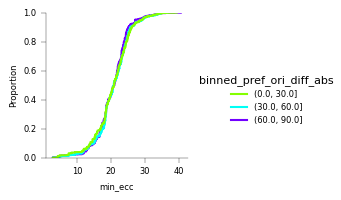

<IPython.core.display.Javascript object>


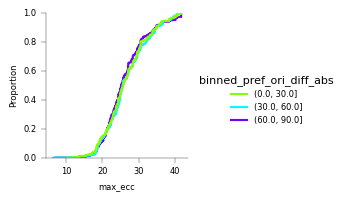

In [961]:
for ai, x_var in enumerate(['min_ecc', 'max_ecc']):

    sns.displot(data=plotd, x=x_var, height=2,
           hue='binned_%s' % hue_label, palette=cmap,
           kind='ecdf')

<IPython.core.display.Javascript object>


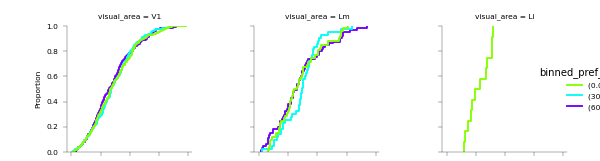

In [457]:
# hue_label = 'pref_ori_diff_abs'
# cmap='hsv'
# currdf['binned_%s' % hue_label], bin_edges = pd.cut(currdf[hue_label], \
#                                                 bin_lut[hue_label], retbins=True)
# plotd0 = currdf[currdf['max_ecc']<=np.inf]
# plotd = plotd0[plotd0['cortical_distance']<=1000].copy()

dist_var = 'cortical_distance'
lower_lim=None
upper_lim=1000
hue_label = 'pref_ori_diff_abs'
hue_bins=bin_lut[hue_label]

df_ = cr.get_bins_within_limits(currdf, bin_name=dist_var, 
                    upper_lim=upper_lim, lower_lim=lower_lim)
df_pass = cr.get_binned_X(df_, x_label=hue_label, x_bins=hue_bins, 
                     min_npairs=min_npairs)

%matplotlib notebook
x_var='cortical_distance'
fg = sns.displot(data=df_pass, col='visual_area', col_order=visual_areas,
           x=dist_var, height=2,
           hue='binned_%s' % hue_label, palette=cmap,
           kind='ecdf')
pl.subplots_adjust(left=0.1, right=0.85, wspace=0.5, bottom=0.15, 
                   hspace=0.7, top=0.85)

# pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, wspace=0.3, top=0.8)
# pplot.label_figure(fg.fig, data_id)
# figname = '%s__%s' % (hue_label, x_var)
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

In [963]:
currdf.groupby(['visual_area', 'binned_%s' % hue_label])['neuron_pair'].count()

visual_area  binned_pref_ori_diff_abs
Li           (0.0, 30.0]                   46
             (30.0, 60.0]                  16
             (60.0, 90.0]                  14
Lm           (0.0, 30.0]                  104
             (30.0, 60.0]                 109
             (60.0, 90.0]                 100
V1           (0.0, 30.0]                 1353
             (30.0, 60.0]                 843
             (60.0, 90.0]                 854
Name: neuron_pair, dtype: int64

<IPython.core.display.Javascript object>


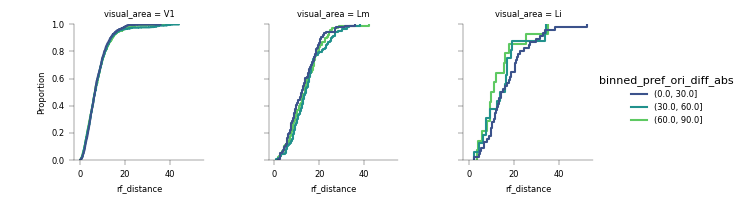

In [964]:
x_var='rf_distance'
hue_label = 'pref_ori_diff_abs'
cmap='viridis'
currdf['binned_%s' % hue_label], bin_edges = pd.cut(currdf[hue_label], \
                                                bin_lut[hue_label], retbins=True)

%matplotlib notebook
sns.displot(data=currdf, x=x_var, hue='binned_%s' % hue_label,
            palette=cmap, kind='ecdf', height=2,
           col='visual_area', col_order=visual_areas, )
# fig, axn = pl.subplots(1,3, figsize=(7,3))
# for va, vg in currdf.groupby('visual_area'):
#     ax=axn[visual_areas.index(va)]
#     ax = sns.histplot(x=x_var, data=vg, hue='binned_%s' % hue_label,
#              ax=ax, bins=20, kde=False, fill=False, element='poly', 
#              palette=cmap, cumulative=False, lw=2)
#     ax.set_title(va)
#     if va!='Li':
#         ax.legend_.remove()
#     else:
#         pplot.sns_histplot_legend(ax, title=hue_label)
pl.subplots_adjust(left=0.1, right=0.8, wspace=0.5, bottom=0.2)

In [825]:
np.arange(0, 45, 5) 

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40])

<IPython.core.display.Javascript object>


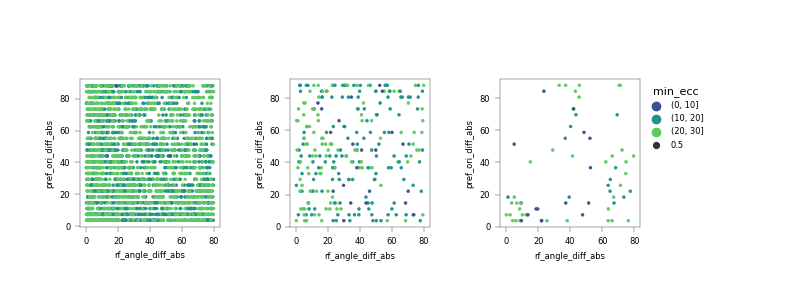

In [826]:

x_var = 'rf_angle_diff_abs'
y_var = 'pref_ori_diff_abs'
hue_label = 'min_ecc'
#test_bins = np.arange(0, 50, 10) 
test_bins = np.arange(0, 40, 10) 

currdf['binned_%s' % hue_label], bin_edges = pd.cut(currdf[hue_label], \
                                                test_bins, retbins=True)

fig, axn = pl.subplots(1,3, figsize=(8,3))
for va, vg in currdf.dropna().groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    sns.scatterplot(x=x_var, y=y_var, data=vg, ax=ax, 
                hue='binned_%s' % hue_label, palette='viridis',
                size=0.5, edgecolor=None, marker='.')
    ax.legend_.remove()
    ax.set_aspect('equal')
axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
              title=hue_label)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.1, wspace=0.5)

<IPython.core.display.Javascript object>


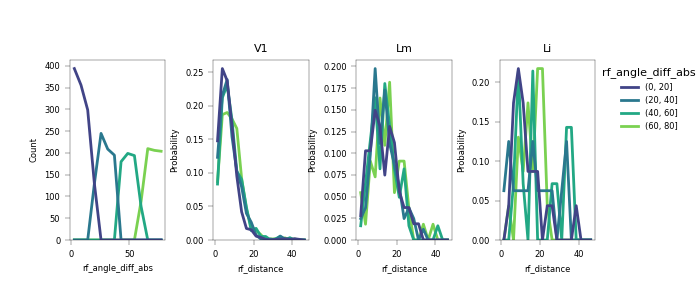

In [829]:
#x_var='pref_ori_diff_abs'
x_var='rf_distance'

hue_label = 'rf_angle_diff_abs'
cmap='viridis'
test_bins = np.arange(0, 90, 20)
currdf['binned_%s' % hue_label], bin_edges = pd.cut(currdf[hue_label], \
                                                test_bins, retbins=True)

%matplotlib notebook
fig, axn = pl.subplots(1,4, figsize=(7,3))
ax=axn[0]
ax = sns.histplot(x=hue_label, data=currdf, hue='binned_%s' % hue_label,
             ax=ax, kde=False, fill=False, element='poly', 
             palette=cmap, cumulative=False, lw=2)
ax.legend_.remove()
for va, vg in currdf.groupby('visual_area'):
    ax=axn[visual_areas.index(va)+1]
    ax = sns.histplot(x=x_var, data=vg, hue='binned_%s' % hue_label,
             ax=ax, bins=bin_lut[x_var], kde=False, fill=False, element='poly', 
             palette=cmap, cumulative=False, lw=2, 
                      stat='probability', common_norm=False)
    ax.set_title(va)
    if va!='Li':
        ax.legend_.remove()
    else:
        pplot.sns_histplot_legend(ax, title=hue_label)
pl.subplots_adjust(left=0.1, right=0.85, wspace=0.5, bottom=0.2, top=0.8)

In [759]:
np.arange(0, 90, 20)

array([ 0, 20, 40, 60, 80])

In [675]:
currdf['binned_%s' % hue_label].dropna().unique()

[(0.0, 15.0], (75.0, 90.0], (30.0, 45.0], (15.0, 30.0], (45.0, 60.0], (60.0, 75.0]]
Categories (6, interval[float64]): [(0.0, 15.0] < (15.0, 30.0] < (30.0, 45.0] < (45.0, 60.0] < (60.0, 75.0] < (75.0, 90.0]]

<IPython.core.display.Javascript object>


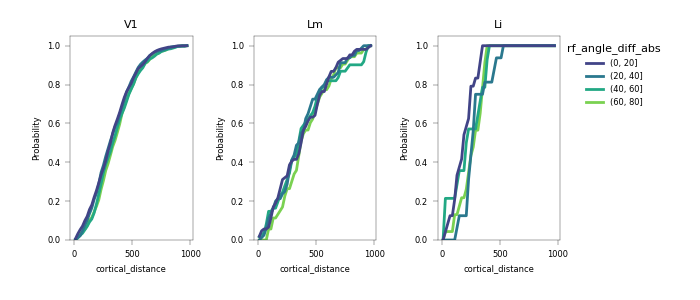

In [761]:
hue_label = 'rf_angle_diff_abs'
rf_ang_bins=np.arange(0, 90, 20)
currdf['binned_%s' % hue_label], bin_edges = pd.cut(currdf[hue_label], \
                                            rf_ang_bins, retbins=True)
x_var='cortical_distance'

%matplotlib notebook
fig, axn = pl.subplots(1,3, figsize=(7,3))
for va, vg in currdf.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    ax = sns.histplot(x=x_var, data=vg, hue='binned_%s' % hue_label,
             ax=ax, bins=ctx_dist_bins, kde=False, fill=False, element='poly', 
             palette='viridis', cumulative=True, lw=2,
                     stat='probability', common_norm=False)
    ax.set_title(va)
    if va!='Li':
        ax.legend_.remove()
    else:
        pplot.sns_histplot_legend(ax, title=hue_label)
pl.subplots_adjust(left=0.1, right=0.8, wspace=0.5, bottom=0.2)

<IPython.core.display.Javascript object>


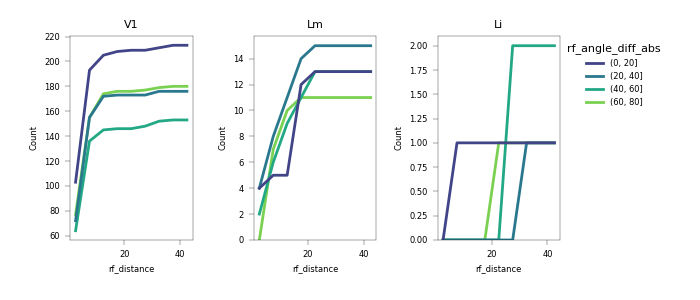

In [512]:
x_var='rf_distance'
hue_label = 'rf_angle_diff_abs'
currdf['binned_%s' % hue_label], bin_edges = pd.cut(currdf[hue_label], \
                                                rf_ang_bins, retbins=True)
%matplotlib notebook
fig, axn = pl.subplots(1,3, figsize=(7,3))
for va, vg in currdf.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    ax = sns.histplot(x=x_var, data=vg, hue='binned_%s' % hue_label,
             ax=ax, bins=rf_dist_bins, kde=False, fill=False, element='poly', 
             palette='viridis', cumulative=True, lw=2)
    ax.set_title(va)
    if va!='Li':
        ax.legend_.remove()
    else:
        pplot.sns_histplot_legend(ax, title=hue_label)
pl.subplots_adjust(left=0.1, right=0.8, wspace=0.5, bottom=0.2)

In [489]:
d_list=[]
big_theta_diffs = currdf[currdf['pref_ori_diff_abs']>70].copy()
for (va, dk), vg in big_theta_diffs.groupby(['visual_area', 'datakey']):
    rois_ = np.union1d(vg['cell_1'].unique(), vg['cell_2'].unique())
    d_ = df[(df.visual_area==va) & (df.datakey==dk) & (df['cell'].isin(rois_))].copy()
    d_list.append(d_)
df_ = pd.concat(d_list)    

In [490]:
# big_theta_diffs[(big_theta_diffs.visual_area=='V1')]\
# .sort_values(by='binned_cortical_distance')
va='V1'
# dk='20191006_JC110_fov1'
# rois_=[102, 103]
dk = '20190617_JC097_fov1'

big_theta_diffs[(big_theta_diffs.visual_area=='V1')
               & (big_theta_diffs.datakey==dk)]\
.sort_values(by='binned_cortical_distance')

,neuron_pair,cell_1,cell_2,pref_dir_diff,pref_dir_diff_abs,pref_ori_diff,pref_ori_diff_abs,rf_angle_diff,rf_angle_diff_abs,response_pref,rf_distance,cortical_distance,visual_area,datakey,n_cells,binned_pref_ori_diff_abs,binned_cortical_distance,binned_rf_angle_diff_abs
2170,60_65,60,65,-73.469388,73.469388,-73.469388,73.469388,-49.075309,49.075309,0.003654,4.111300,78.358030,V1,20190617_JC097_fov1,25,"(60, 75]","(60, 80]","(40.0, 60.0]"
2073,21_224,21,224,-73.469388,73.469388,-73.469388,73.469388,33.308342,33.308342,0.113392,2.716344,148.272296,V1,20190617_JC097_fov1,25,"(60, 75]","(140, 160]","(20.0, 40.0]"
2061,21_40,21,40,95.510204,95.510204,-84.489796,84.489796,48.870764,48.870764,0.088488,1.284756,172.585419,V1,20190617_JC097_fov1,25,"(75, 90]","(160, 180]","(40.0, 60.0]"
2074,21_230,21,230,-95.510204,95.510204,84.489796,84.489796,-40.726048,40.726048,0.014190,1.370605,164.514191,V1,20190617_JC097_fov1,25,"(75, 90]","(160, 180]","(40.0, 60.0]"
2166,50_420,50,420,-95.510204,95.510204,84.489796,84.489796,-27.808300,27.808300,0.023583,3.369821,181.485383,V1,20190617_JC097_fov1,25,"(75, 90]","(180, 200]","(20.0, 40.0]"
2152,50_92,50,92,-95.510204,95.510204,84.489796,84.489796,-46.394327,46.394327,0.002935,1.979609,192.227941,V1,20190617_JC097_fov1,25,"(75, 90]","(180, 200]","(40.0, 60.0]"
2221,92_424,92,424,-88.163265,88.163265,-88.163265,88.163265,78.514342,78.514342,0.017713,6.847941,201.761615,V1,20190617_JC097_fov1,25,"(75, 90]","(200, 220]","(60.0, 80.0]"
2209,92_162,92,162,95.510204,95.510204,-84.489796,84.489796,-13.282088,13.282088,0.013920,8.136644,205.629811,V1,20190617_JC097_fov1,25,"(75, 90]","(200, 220]","(0.0, 20.0]"
2188,60_432,60,432,-80.816327,80.816327,-80.816327,80.816327,14.072958,14.072958,0.028909,3.806933,201.439102,V1,20190617_JC097_fov1,25,"(75, 90]","(200, 220]","(0.0, 20.0]"
2243,142_203,142,203,95.510204,95.510204,-84.489796,84.489796,-15.709776,15.709776,0.128950,3.978044,225.252446,V1,20190617_JC097_fov1,25,"(75, 90]","(220, 240]","(0.0, 20.0]"


In [491]:
va='V1'
# dk='20191006_JC110_fov1'
# rois_=[102, 103]
dk = '20190617_JC097_fov1'
df_[(df_.visual_area==va) & (df_.datakey==dk)]\
[['cell', 'theta_pref', 'response_pref', 'asi', 'dsi', 'gof', 'sf', 'size', 'speed']]
# rois_ = [69, 73]
# df_[(df_.visual_area==va) & (df_.datakey==dk) & (df_.cell.isin(rois_))]\
# [['cell', 'theta_pref', 'response_pref', 'asi', 'dsi']]

,cell,theta_pref,response_pref,asi,dsi,gof,sf,size,speed
218,21,0.000000,0.071097,0.419196,0.560769,0.515804,0.5,200.0,10.0
219,25,124.897959,0.097348,0.544721,0.226399,0.515422,0.5,20.0,20.0
220,40,95.510204,0.159585,0.494238,0.156271,0.536622,0.1,20.0,20.0
222,50,88.163265,0.109166,0.384916,0.499996,0.638187,0.5,200.0,10.0
223,60,308.571429,0.138274,0.200429,0.484791,0.512174,0.5,20.0,20.0
224,65,235.102041,0.134620,0.142898,0.421928,0.530916,0.5,200.0,20.0
225,92,352.653061,0.112101,0.622714,0.281595,0.544758,0.1,20.0,20.0
226,107,213.061224,0.114031,0.210019,0.573874,0.566227,0.5,200.0,20.0
227,142,80.816327,0.083951,0.685170,0.141031,0.605964,0.1,200.0,10.0
228,162,88.163265,0.098181,0.705657,0.432000,0.572517,0.5,200.0,10.0


<IPython.core.display.Javascript object>


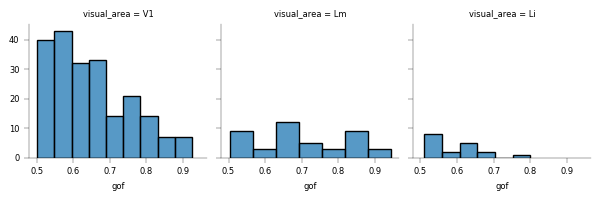

In [417]:
fg = sns.FacetGrid(data=df_, col='visual_area', col_order=visual_areas, height=2)
fg.map(sns.histplot, 'gof')

<IPython.core.display.Javascript object>


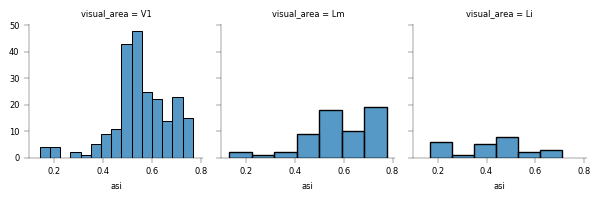

In [321]:
fg = sns.FacetGrid(data=df_, col='visual_area', col_order=visual_areas, height=2)
fg.map(sns.histplot, 'asi')

<IPython.core.display.Javascript object>


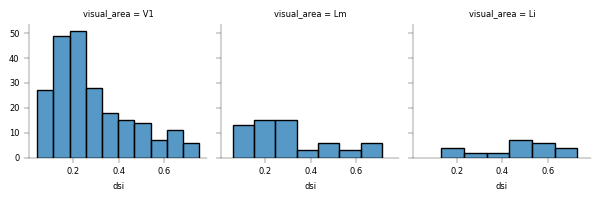

In [322]:
fg = sns.FacetGrid(data=df_, col='visual_area', col_order=visual_areas, height=2)
fg.map(sns.histplot, 'dsi')

In [298]:
print(angdists.groupby(['visual_area'])['cortical_distance'].max())

angdists0 = angdists[angdists['cortical_distance']<=500].copy()

visual_area
Li     535.671223
Lm    1066.254662
V1    1160.609688
Name: cortical_distance, dtype: float64


In [309]:
# ------------------------------
cmap='viridis'
custom_bins=False
# ------------------------------
# Bin data
to_quartile='rf_distance'
n_bins=20
use_quartile=False
# ---------------------------------
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                            cmap=cmap)
bcorrs, bins_ = cr.bin_column_values(angdists0, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
bcorrs = bcorrs.dropna()
# Add bin value to df
bin_values = bcorrs.groupby(['binned_%s' % to_quartile])[to_quartile].median()
bin_lut = dict((k, v) for k, v in zip(bin_labels, bin_values))
bcorrs['bin_value'] = [bin_lut[b] for b in bcorrs['binned_%s' % to_quartile]]

# Count N pairs in each bin
pairs_per_bin = bcorrs.groupby(['visual_area', 'binned_%s' % to_quartile])\
                ['neuron_pair'].count().reset_index()\
                .rename(columns={'neuron_pair': 'n_pairs'})
pairs_per_bin['bin_value'] = [bin_lut[b] for b \
                               in pairs_per_bin['binned_%s' % to_quartile]]
# bin_column='bin_value'

<IPython.core.display.Javascript object>


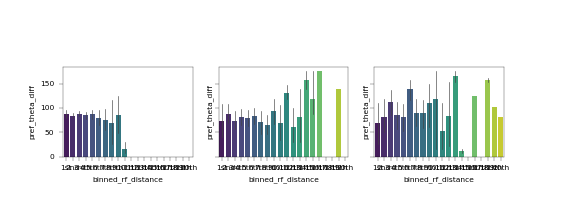

In [310]:
y_var='pref_theta_diff'
x_var = 'binned_%s' % to_quartile

n_iter=int(np.random.rand(1)[0]*500)
min_npairs = 5
n_iter=100

xlabel='cortical distance (um)' if to_quartile=='cortical_distance' \
            else 'RF distance (deg)'
cnt_grouper = [x_var] 

fig, axn = pl.subplots(1,3, figsize=(7,2.5), sharex=True, sharey=True)
for va, cc0 in bcorrs.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    cnts = cc0.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(cnts[cnts>min_npairs].index.tolist(),
                               cnts[cnts>min_npairs].values))
    # Sample
    cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                         for c, cg in cc0.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])
    # fov mean for visualizing
    fov_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    # plot
    sns.barplot(x=x_var, y=y_var, data=cc0, ax=ax, palette='viridis',
               estimator=np.mean, errwidth=0.5)

pl.subplots_adjust(bottom=0.3, left=0.1, right=0.8, top=0.7)


<IPython.core.display.Javascript object>


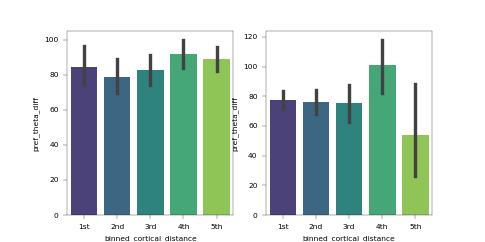

In [311]:
near_ = angdists[angdists['cortical_distance']<=250].copy()
far_ = angdists[angdists['cortical_distance']>=500].copy()
y_var = 'pref_theta_diff'

# Bin data
to_quartile='cortical_distance'
n_bins=5
use_quartile=False
# ---------------------------------
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                            cmap=cmap)
near_, bins_ = cr.bin_column_values(near_, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
far_, bins_ = cr.bin_column_values(far_, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
fig, axn = pl.subplots(1, 2, figsize=(6,3))
ax=axn[0]
sns.barplot(x='binned_%s' % to_quartile, y=y_var, data=near_, ax=ax,
           palette='viridis')
ax=axn[1]
sns.barplot(x='binned_%s' % to_quartile, y=y_var, data=far_, ax=ax,
           palette='viridis')
pl.subplots_adjust(bottom=0.2, right=0.8)

In [312]:
angdists['pref_theta_diff']

0         7.346939
1        88.163265
2         7.346939
3       139.591837
4         0.000000
           ...    
2770    146.938776
2771    168.979592
2772    154.285714
2773    161.632653
2774     44.081633
Name: pref_theta_diff, Length: 2775, dtype: float64

In [314]:
x_var='rf_distance'
print(angdists.groupby(['visual_area'])[x_var].max())


curr_df = angdists[angdists[x_var]<=50].copy()

visual_area
Li    53.261005
Lm    49.531952
V1    31.980850
Name: rf_distance, dtype: float64


In [315]:
near_lim = 20
far_lim = 30
near_ = curr_df[curr_df[x_var]<near_lim].copy()
far_ = curr_df[curr_df[x_var]>far_lim].copy()

# Bin data
to_quartile='pref_theta_diff'
n_bins=5
use_quartile=False
# ---------------------------------
# bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
#                                             cmap=cmap)
bins=[0, 45, 90, 135, 180]
bin_labels=bins[0:-1]

near_['binned_%s' % to_quartile], bin_edges = pd.cut(near_[to_quartile], \
                                                bins, labels=None, retbins=True)
near_['distance_label'] = 'd<%i um' % near_lim
near_['distance'] = 'near'

far_['binned_%s' % to_quartile], bin_edges = pd.cut(far_[to_quartile], \
                                                bins, labels=None, retbins=True)
far_['distance_label'] = 'd>%i um' % far_lim
far_['distance'] = 'far'


dists = pd.concat([near_, far_], axis=0, ignore_index=True)

# near_, bins_ = cr.bin_column_values(near_, to_quartile=to_quartile, 
#                      use_quartile=use_quartile, return_bins=True,
#                      n_bins=n_bins, bins=bins, labels=bin_labels)
# far_, bins_ = cr.bin_column_values(far_, to_quartile=to_quartile, 
#                      use_quartile=use_quartile, return_bins=True,
#                      n_bins=n_bins, bins=bins, labels=bin_labels)

<IPython.core.display.Javascript object>


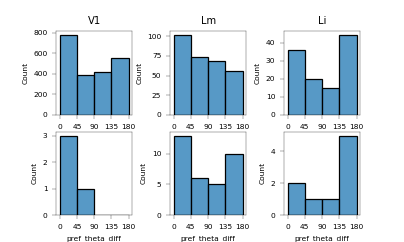

In [316]:
fig, axn = pl.subplots(2, 3, figsize=(5,3))
for va, vg in dists.groupby('visual_area'):
    ai = visual_areas.index(va)
    ax=axn[0, ai]
    ax.set_title(va)
    sns.histplot(x='pref_theta_diff', data=vg[vg['distance']=='near'], 
                 ax=ax, bins=bins)
    ax=axn[1, ai]
    sns.histplot(x='pref_theta_diff', data=vg[vg['distance']=='far'], ax=ax, bins=bins)

for ax in axn.flat:
    ax.set_xticks(bins)
pl.subplots_adjust(bottom=0.2, right=0.8, wspace=0.5)

In [162]:
cnts_near = near_.groupby(['visual_area', 'binned_%s' % to_quartile])['neuron_pair']\
                 .count().reset_index()
cnts_near['distance'] = 'near'
cnts_far = far_.groupby(['visual_area', 'binned_%s' % to_quartile])['neuron_pair']\
                 .count().reset_index()
cnts_far['distance'] = 'far'

cnts = pd.concat([cnts_far, cnts_near], axis=0)
cnts

,visual_area,binned_pref_theta_diff,neuron_pair,distance
0,Li,"(0, 45]",97,far
1,Li,"(45, 90]",40,far
2,Li,"(90, 135]",0,far
3,Li,"(135, 180]",0,far
4,Lm,"(0, 45]",150,far
5,Lm,"(45, 90]",127,far
6,Lm,"(90, 135]",0,far
7,Lm,"(135, 180]",0,far
8,V1,"(0, 45]",990,far
9,V1,"(45, 90]",641,far


<IPython.core.display.Javascript object>


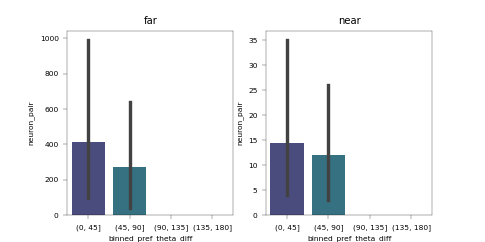

In [163]:
fig, axn = pl.subplots(1, 2, figsize=(6,3))
for ax, (cd, cg) in zip(axn.flat, cnts.groupby('distance')):
    sns.barplot(x='binned_%s' % to_quartile, y='neuron_pair', data=cg, ax=ax,
           palette='viridis')
    ax.set_title(cd)
pl.subplots_adjust(bottom=0.2, right=0.8)

In [ ]:
va='V1' 
df_ = angdists[(angdists.visual_area==va)].copy()
fg = sns.lmplot(x='rf_distance', y='rf_angle_diff', data=df_, 
            col='datakey', height=2, col_wrap=4, 
            scatter_kws={'s': 0.5, 'color': 'k'},
            line_kws={'color': area_colors[va]})
fg.fig.text(0, 0.95, va, fontsize=12)
for ax in fg.axes:
    ax.set_ylim([0, 90])
pl.subplots_adjust(bottom=0.1, left=0.05,top=0.8)

In [ ]:
va='V1'
df_ = angdists[(angdists.visual_area==va)].copy()
fg = sns.lmplot(x='rf_distance', y='pref_theta_diff', data=df_, 
            col='datakey', height=2, col_wrap=4, 
            scatter_kws={'s': 0.5, 'color': 'k'},
            line_kws={'color': area_colors[va]})
fg.fig.text(0, 0.95, va, fontsize=12)
for ax in fg.axes:
    ax.set_ylim([0, 90])
pl.subplots_adjust(bottom=0.1, left=0.05,top=0.8)

In [ ]:
va='V1'
df_ = angdists[(angdists.visual_area==va)].copy()
fg = sns.lmplot(x='rf_angle_diff', y='pref_theta_diff', data=df_, 
            col='datakey', height=2, col_wrap=4, 
            scatter_kws={'s': 0.5, 'color': 'k'},
            line_kws={'color': area_colors[va]})
fg.fig.text(0, 0.95, va, fontsize=12)
for ax in fg.axes:
    ax.set_ylim([0, 90])
pl.subplots_adjust(bottom=0.1, left=0.05,top=0.8)

In [ ]:
va='Li'
df_ = angdists[(angdists.visual_area==va)].copy()
fg = sns.lmplot(x='rf_angle_diff', y='pref_theta_diff', data=df_, 
            col='datakey', height=2, col_wrap=4, 
            scatter_kws={'s': 1, 'color': 'k'},
            line_kws={'color': area_colors[va]})
fg.fig.text(0, 0.95, va, fontsize=12)
for ax in fg.axes:
    ax.set_ylim([0, 90])
pl.subplots_adjust(bottom=0.2, left=0.05,top=0.8)

In [ ]:
va='Li'
df_ = angdists[(angdists.visual_area==va)].copy()
fg = sns.lmplot(x='rf_distance', y='pref_theta_diff', data=df_, 
            col='datakey', height=2, col_wrap=4, 
            scatter_kws={'s': 1, 'color': 'k'},
            line_kws={'color': area_colors[va]})
fg.fig.text(0, 0.95, va, fontsize=12)
for ax in fg.axes:
    ax.set_ylim([0, 90])
pl.subplots_adjust(bottom=0.2, left=0.05,top=0.8)

In [ ]:
va='Li'
df_ = angdists[(angdists.visual_area==va)].copy()
fg = sns.lmplot(x='rf_distance', y='rf_angle_diff', data=df_, 
            col='datakey', height=2, col_wrap=4, 
            scatter_kws={'s': 1, 'color': 'k'},
            line_kws={'color': area_colors[va]})
fg.fig.text(0, 0.95, va, fontsize=12)
for ax in fg.axes:
    ax.set_ylim([0, 90])
pl.subplots_adjust(bottom=0.2, left=0.05,top=0.8)

### Signal corrs

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

{0: 'r', 315: 'r', 180: 'b', 225: 'b'}


<IPython.core.display.Javascript object>


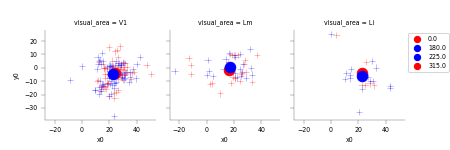

V1: nasal=(24.2, -4.1) | temporal (22.3, -4.9)
Lm: nasal=(16.7, -1.8) | temporal (17.2, 0.8)
Li: nasal=(22.8, -3.6) | temporal (22.6, -6.4)


In [311]:
# 0: Nasal, 180: Temporal
# 90: Upward, 270: Downward
nasal_color = 'r'
temporal_color='b'
nasal_ = [0, 315]
temporal_ = [180, 225]

theta_colors = dict((k, nasal_color) for k in nasal_)
theta_colors.update(dict((k, temporal_color) for k in temporal_))
print(theta_colors)

curr_oris = theta_colors.keys() #[0, 180]

currdata = DF[(DF['dsi']>=0.1) & (DF['tested_theta'].isin(curr_oris))].copy()

fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, height=2,
                   data=currdata)
fg.map(sns.scatterplot, 'x0', 'y0', 'tested_theta', #palette=theta_colors,
      alpha=0.5, palette=theta_colors, marker='+', facecolor='none')
# sns.scatterplot(x='x0', y='y0', hue='tested_theta', data=df_, ax=ax,
#                palette=theta_colors)
pl.legend(loc='upper left', bbox_to_anchor=(1,1))
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

for ai, va in enumerate(visual_areas):
    ax = fg.axes.flat[ai]
    df_ = currdata[currdata.visual_area==va].copy()
    cx_n, cy_n = hutils.CoM(df_[df_['tested_theta'].isin(nasal_)][['x0', 'y0']])
    cx_t, cy_t = hutils.CoM(df_[df_['tested_theta'].isin(temporal_)][['x0', 'y0']])
    
    ax.plot(cx_n, cy_n, color=nasal_color, marker='o', markersize=10)
    ax.plot(cx_t, cy_t, color=temporal_color, marker='o', markersize=10)

    print('%s: nasal=(%.1f, %.1f) | temporal (%.1f, %.1f)' % (va, cx_n, cy_n, cx_t, cy_t))
    

In [282]:
%matplotlib notebook

# Compare difference in preferred dirs

In [1420]:
c_ = []
for (va, dk), cc_ in corrdist.groupby(['visual_area', 'datakey']):
    # Get current FOV rfdata and add position info to sigcorrs df
    gfit_ =  passg[(passg.visual_area==va) & (passg.datakey==dk)
                  & (passg['asi']>=0.2)].copy()
    gfit_.index = gfit_['cell'].values
    rois_ =  gfit_['cell'].unique()
    if len(rois_)==0:
        continue
    tmpc = cc_[cc_['cell_1'].isin(rois_) & cc_['cell_2'].isin(rois_)].copy()
    diff_theta = gfit_.loc[tmpc['cell_1']]['theta_pref'].values \
                    - gfit_.loc[tmpc['cell_2']]['theta_pref'].values
    v = diff_theta % 360.
    thetas_range = ((v - 180) % 360) - 180 # -180, 180
    #to_deg = np.array([np.rad2deg(i) for i in thetas_range])
    #print(min(to_deg), max(to_deg))
#     thetas_range = [ (theta + 90) % 360 if (90 <= theta < 360) \
#         else (((theta) % 90) + 90) % 360 for theta in v]
#     thetas_range = np.array([(t % 180.) - 180. if ((90<t<180) or (270<t<360)) \
#                      else (t % 180.) for t in v ])
    #thetas_range2 = (v + 180) % 180. # (0, 180)
    tmpc['pref_theta_diff'] = thetas_range #% 360. #% 180.
    c_.append(tmpc)
fitdist = pd.concat(c_, axis=0).reset_index(drop=True)

fitdist['pref_theta_diff'].min(), fitdist['pref_theta_diff'].max() # Range from -180 to 180

(-176.32653061224494, 176.32653061224494)

In [1421]:
fitdist

,cell_1,cell_2,signal_cc,neuron_pair,noise_cc,visual_area,datakey,cortical_distance,binned_dist,pref_theta_diff
0,172,187,-0.478374,172_187,0.044495,Li,20190314_JC070_fov1,217.661674,100-300,95.510204
1,172,216,0.727695,172_216,0.246881,Li,20190314_JC070_fov1,451.735098,300-500,-7.346939
2,172,220,0.783481,172_220,-0.004236,Li,20190314_JC070_fov1,456.918526,300-500,-7.346939
3,172,235,0.099065,172_235,-0.005421,Li,20190314_JC070_fov1,662.784857,>500,124.897959
4,172,253,0.135893,172_253,0.067974,Li,20190314_JC070_fov1,468.471708,300-500,-58.775510
...,...,...,...,...,...,...,...,...,...,...
18042,237,266,0.460840,237_266,0.240423,V1,20191006_JC110_fov1,172.559270,100-300,-161.632653
18043,237,313,0.504684,237_313,0.081655,V1,20191006_JC110_fov1,359.807776,300-500,51.428571
18044,245,266,0.708482,245_266,0.408278,V1,20191006_JC110_fov1,96.025434,<100,-168.979592
18045,245,313,0.457018,245_313,0.116141,V1,20191006_JC110_fov1,443.795066,300-500,44.081633


In [1422]:
# # Bin cortical distances for plotting
# -----------------------------------------------
# n_bins_dist = 5
# use_quartile=False
# bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
# print("binning: %s" % bin_type)
# if use_quartile:
#     fitdist['binned_dist'], bin_edges = pd.qcut(fitdist['cortical_distance'], \
#                                     n_bins_dist, labels=False, retbins=True)
# else:
#     fitdist['binned_dist'], bin_edges = pd.cut(fitdist['cortical_distance'], \
#                                      n_bins_dist,labels=False, retbins=True)

#fitdist['binned_dist'] = None
# bins_ = [0, 100, 200, 300, 400, 500, np.inf]
# dist_labels = ['<100', '100-200', '200-300', '300-400', '400-500', '>500']

bins_ = [0, 150, 300, 450, np.inf]
dist_labels=[]
for i, b in enumerate(bins_[0:-1]):
    if i==0:
        dist_labels.append('<%i' % bins_[i+1])
    elif i==len(bins_)-2:
        dist_labels.append('>%i' % bins_[-2])
    else:
        dist_labels.append('%i-%i' % (b, bins_[i+1]))
# dist_labels = ['<100', '100-300', '300-500', '>500']
print(dist_labels)
fitdist['binned_dist'] = pd.cut(x=fitdist['cortical_distance'], 
                                bins=bins_,labels=dist_labels)


['<150', '150-300', '300-450', '>450']


In [1434]:
# bin thetas
# -----------------------------------------------
#metric='abs_diff'
metric = 'pref_theta_diff'
if metric=='abs_diff':
    fitdist['abs_diff'] = np.abs(fitdist['pref_theta_diff'])
    bins_ = np.linspace(0, 180, 6)
    theta_labels = np.linspace(0, 180, 6)[0:-1]
    fitdist['binned_theta'] = pd.cut(x=fitdist['abs_diff'],
                                     bins=bins_, labels=theta_labels)
else:
    bins_ = [-np.inf]
    vmin=-180; vmax=180;
    n_steps = 10
    int_size = np.mean(np.diff(np.linspace(vmin, vmax, n_steps)))

    rg = np.linspace(vmin, vmax, n_steps) + int_size/2.
    bins_.extend(rg[0:-1])
    bins_.append(np.inf)
    theta_labels = np.linspace(vmin, vmax, n_steps)
    fitdist['binned_theta'] = pd.cut(x=fitdist['pref_theta_diff'],
                                     bins=bins_, labels=theta_labels)
print(bins_)
print(theta_labels)

[-inf, -160.0, -120.0, -80.0, -40.0, 0.0, 40.0, 80.0, 120.0, 160.0, inf]
[-180. -140. -100.  -60.  -20.   20.   60.  100.  140.  180.]


<IPython.core.display.Javascript object>


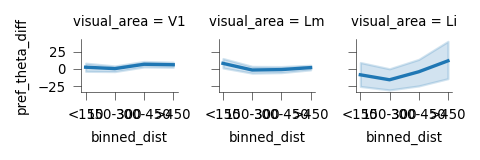

In [1435]:
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=fitdist, height=1)
fg.map(sns.lineplot, 'binned_dist', metric)

In [1436]:
# fitdist['abs_diff_rad'] = [np.deg2rad(i) for i in fitdist['abs_diff'].values]

# fitdist['binned_rad'] = [np.deg2rad(i) for i in fitdist['binned_theta'].values]

# print(fitdist['abs_diff_rad'].min(), fitdist['abs_diff_rad'].max())
# print(fitdist['binned_rad'].min(), fitdist['binned_rad'].max())
# fitdist.head()

In [1437]:
# Mean by FOV
mean_fitdist = fitdist.groupby(
                ['visual_area', 'datakey', 'binned_dist', 'binned_theta'])\
                .mean().reset_index().dropna()
mean_fitdist.head()
# cols = ['visual_area', 'datakey', 'binned_dist', 'binned_rad', 'abs_diff_rad']
# groups = ['visual_area', 'datakey', 'binned_dist', 'binned_rad']
# mean_fitdist = fitdist[cols].groupby(groups)\
#                         .apply(spstats.circmean, 
#                         high=np.pi, low=0, nan_policy='omit').reset_index()\
#                         .rename(columns={0: 'abs_diff_rad'})
# mean_fitdist['abs_diff'] = [np.rad2deg(i) for \
#                                     i in mean_fitdist['abs_diff_rad'].values]
# mean_fitdist['binned_theta'] = [np.rad2deg(i) for \
#                                     i in mean_fitdist['binned_rad'].values]

,visual_area,datakey,binned_dist,binned_theta,cell_1,cell_2,signal_cc,noise_cc,cortical_distance,pref_theta_diff,abs_diff
40,Li,20190314_JC070_fov1,<150,-180.0,297.0,318.0,0.050655,0.433490,107.332928,-176.326531,176.326531
41,Li,20190314_JC070_fov1,<150,-140.0,279.0,297.0,-0.149087,-0.083493,107.157176,-154.285714,154.285714
43,Li,20190314_JC070_fov1,<150,-60.0,218.0,253.0,0.293214,0.181292,101.372948,-51.428571,51.428571
44,Li,20190314_JC070_fov1,<150,-20.0,254.0,270.5,0.541135,0.144238,93.358755,-18.367347,18.367347
51,Li,20190314_JC070_fov1,150-300,-140.0,211.0,259.5,-0.128815,0.023185,271.443274,-154.285714,154.285714


In [1438]:
# d_=[]
# for (va, dk, b_dist, b_theta), g in fitdist.groupby(
#         ['visual_area', 'datakey', 'binned_dist', 'binned_theta']):
#     cells_in_bin = np.union1d(g['cell_1'].unique(), g['cell_2'].unique())
#     df_ = pd.DataFrame({'cell': cells_in_bin})
#     df_['visual_area'] = va
#     df_['datakey'] = dk
#     df_['binned_dist'] = b_dist
#     df_['binned_theta'] = b_theta
#     d_.append(df_)
# cells_in_bin = pd.concat(d_)

In [1439]:
# meanfit = fitdist.groupby(
#             ['visual_area', 'datakey', 'binned_dist'])['abs_diff']\
#             .mean().dropna().reset_index()
# meanfit.groupby(['visual_area', 'binned_dist']).mean()

<IPython.core.display.Javascript object>


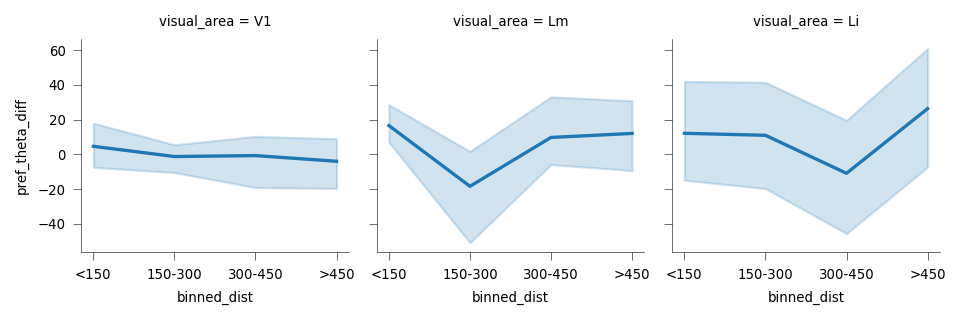

In [1440]:
meanfit = fitdist.groupby(
            ['visual_area', 'datakey', 'binned_dist'])[metric]\
            .mean().dropna().reset_index()
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=meanfit, height=2)
fg.map(sns.lineplot, 'binned_dist', metric)

In [1441]:
counts = fitdist.groupby(['visual_area', 'binned_dist', 'binned_theta'])\
            ['neuron_pair'].count().reset_index()\
        .rename(columns={'neuron_pair': 'n_theta_bin'})
counts
counts['n_dist_bin'] = None
for (va, bd), g in counts.groupby(['visual_area', 'binned_dist']):
    counts.loc[g.index, 'n_dist_bin'] = g['n_theta_bin'].sum()
counts['fraction'] = counts['n_theta_bin'] / counts['n_dist_bin'].astype(float)

<IPython.core.display.Javascript object>


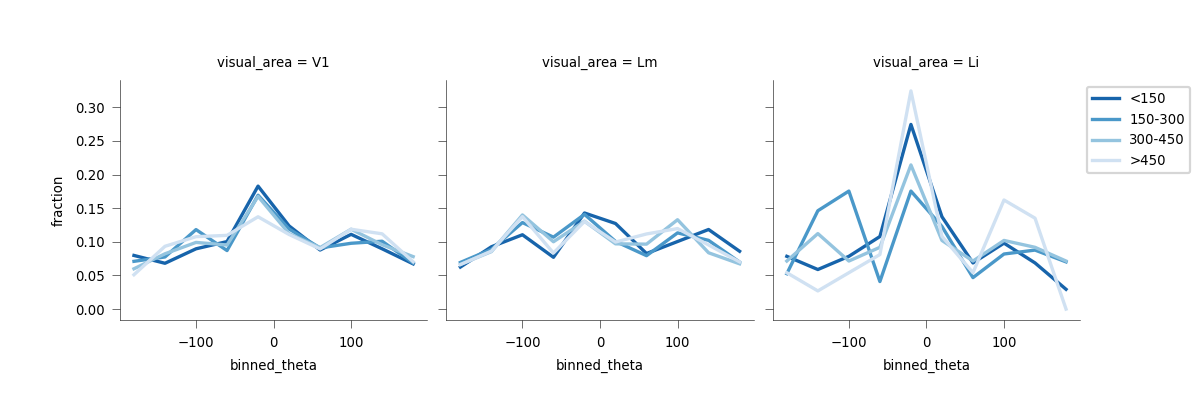

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

In [1442]:
dist_c = sns.color_palette('Blues_r', n_colors=len(dist_labels))
dist_colors = dict((k, v) for k, v in zip(dist_labels, dist_c))

#{'<150': 'b', '150-300': 'g', '300-450': 'r', '>450': 'k'}
plotd = counts.copy() #[counts['binned_dist']!='>450']
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=plotd,
                  height=2.5)
fg.map(sns.lineplot, 'binned_theta', 'fraction', 'binned_dist',
      palette=dist_colors)

pl.legend(loc='upper left', bbox_to_anchor=(1,1))
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

<IPython.core.display.Javascript object>


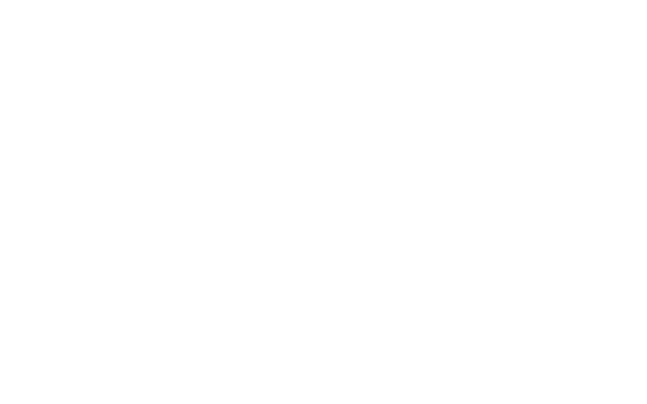

Text(0.0, 0.95, 'Common to RFs/gratings (GoF=0.50)')

In [31]:
gof_thr=0.5
# if pass_gof:
#     plotd = finaldf[finaldf['gof']>gof_thr].copy().dropna()
# else:
plotd = finaldf.copy()
rf_color='k'
ori_color='cornflowerblue'
ell_icon_height = 5
alpha=0.5
bar_width=15.
bin_size = 10
# -----------------------------------------
max_ori = 360.
ori_names = np.arange(0, max_ori+45, 45)
ori_bins = np.arange(0, max_ori+bin_size, bin_size)

rf_names = np.arange(-90, 90+45, 45)
rf_bins = np.arange(-90, 90+bin_size, bin_size)
# plot.
fig = pl.figure(figsize=(8,5))
i=0
for vi, visual_area in enumerate(visual_areas):
    g = plotd[plotd['visual_area']==visual_area].copy()
    # First, do PREFERRED THETA
    degrees = g['theta_pref'].values % max_ori #% 180.
    radians = np.rad2deg(degrees)
    bin_counts, bin_vals = np.histogram(degrees, bins=ori_bins)
    centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])
    ax = pl.subplot(2, 3, vi+1, projection='polar')
    ax.bar(centers, bin_counts, width=np.deg2rad(bar_width), bottom=0.0, 
               facecolor=ori_color, alpha=0.7, edgecolor="none", 
               color=ori_color, linewidth=0.5)
    ax.set_title('%s' % (visual_area), loc='center', fontsize=12, y=1.2)
    ax.text(ax.get_xlim()[0], ax.get_ylim()[-1]*1.3, 
            '(n=%i cells)' % g.shape[0], fontsize=6, horizontalalignment='center')
    # Set ticks
    ax.set_theta_zero_location("N")
    ax.set_rlabel_position(45)
    ori_names = np.arange(0, 360, 45) #np.rad2deg(xticks)
    pplot.replace_ori_labels(ori_names, ax=ax, 
                    xybox=(0, 0), yloc=ax.get_ylim()[-1]*1.1, zoom=0.12, polar=True)
    ax.set_yticks(np.linspace(0, round(ax.get_ylim()[-1]), 4))
    #ax.set_yticklabels([])
    # Now, do RECEPTIVE FIELD angles
    degrees = np.rad2deg(g['theta_Mm_c'].values) #. #- 90.
    bin_counts, bin_vals = np.histogram(degrees, bins=rf_bins)
    centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])
    ax = pl.subplot(2, 3, vi+3+1, projection='polar')
    ax.bar(centers, bin_counts, width=np.deg2rad(bar_width), bottom=0.0, 
           color=rf_color, alpha=0.5, edgecolor=rf_color, lw=0.5)
    ax.set_theta_zero_location("N")
    # Set ticks
    ax.set_xlim([-np.pi/2., np.pi/2.])
    ax.set_xticks(np.arange(-np.pi/2., np.pi/2. + (np.pi/4.), np.pi/4.))
    ax.set_yticks(np.linspace(0, round(ax.get_ylim()[-1]), 4))
    #ax.set_yticklabels([])
    yloc = ax.get_ylim()[-1]*1.1 # + 4
    pplot.replace_rf_labels(rf_names, ax=ax, alpha=alpha,
                    width=ell_icon_height*2., height=ell_icon_height, color='k', 
                    yloc=yloc, lw=1, box_alignment=(1, 1), 
                    xybox=(-ell_icon_height/2., 1))
    i+=2
pplot.label_figure(fig, data_id)
pl.subplots_adjust(left=0.15, wspace=0.5, hspace=0.2, top=0.8,
                   right=0.95, bottom=0.1)

fig.text(0.05, 0.85, "Pref. thetas", horizontalalignment='left', fontsize=6)
fig.text(0.05, 0.4, "R.F. angles", horizontalalignment='left', fontsize=6)
fig.text(0.0, 0.95, "Common to RFs/gratings (GoF=%.2f)" % gof_thr, 
             horizontalalignment='left', fontsize=8)

# figname = 'polar_theta_v_RFangles__gof%.2f_%s' % (gof_thr, dset_str)
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

In [ ]:
def split_by_angle(df_, bin_value, metric='theta_Mm_deg', 
                   boundary_value=180, bin_size=45, combine_zero=True):
    
    ori_bins = np.arange(-boundary_value, boundary_value+bin_size, bin_size)
        
    #angles = (degs + 180.) % (2*180.) - 180.
    half_bin = bin_size/2.

    if bin_value == -boundary_value:
        bmin = boundary_value - half_bin # 90 - 22.5
        bmax = -boundary_value + half_bin  # -90 + 22.5 
        if combine_zero:
            curr_vs = df_[ (df_[metric] >= bmin) | (df_[metric] <= bmax) ]
            #n_in_bin = len(angles[(angles >= bmin) | (angles<=bmax)])
        else:
            curr_vs = df_[df_[metric]<=bmax]
            #n_in_bin = len(angles[angles<=bmax])
    elif bin_value == boundary_value:
        bmin = boundary_value - half_bin
        bmax = -boundary_value + half_bin
        if combine_zero:
            curr_vs = df_[ (df_[metric] >= bmin) | (df_[metric] <= bmax) ]
            #n_in_bin = len(angles[(angles >= bmin) | (angles<=bmax)])
        else:
            curr_vs = df_[df_[metric] >= bmin]
            #n_in_bin = len(angles[angles>=bmin])
    else:
        bmin = bin_value - half_bin
        bmax = bin_value + half_bin
        curr_vs = df_[ (df_[metric] >= bmin) & (df_[metric] <= bmax) ]
        #n_in_bin = len(angles[(angles >= bmin) & (angles<=bmax)])

    #n_in_bin = np.where([angles<])
    #bin_counts.append(n_in_bin)

    return curr_vs #bin_counts, ori_bins

In [ ]:
rf_color='k'
ori_color='cornflowerblue'

plotd = finaldf.copy()
yloc=0.5
rf_bin_size = 45
rf_boundary_value = 90 #np.pi/2.
rf_bins = np.arange(-rf_boundary_value, rf_boundary_value + rf_bin_size, rf_bin_size) #% 180.
rf_bin_span=22.5 #22.5 #.5 #22.5
rf_theta_param = 'rf_theta_deg' #'theta_deg'
##### 
bar_width=30
ori_bin_span=22.5 #2.5 #22.5 #22.5
####
aniso_thr=0.1
filter_aniso=False
max_ori=360.
mod_val=360.
n_bins_dist = 8 if max_ori==360. else 4
ori_bins = np.arange(-180, 180+45, 45)
ori_names = np.arange(0, max_ori+45, 45)
label_unit='degrees'
# =====================================================
# PLOT
# =====================================================
fig, axn = pl.subplots(3, len(rf_bins)-1, figsize=(8,6),sharex=True)
pl.subplots_adjust(wspace=0.5, hspace=0.5, top=0.8, left=0.11, right=0.95)
offset=0.25
for va, df_ in plotd.groupby(['visual_area']):
    vi = visual_areas.index(va) #vi, va in enumerate(visual_areas):
    #df_ = DF[(DF['visual_area']==va)].copy()
    print('%s:: %i cells' % (va, df_.shape[0]))
    if filter_aniso:
        df_ = df_[df_['anisotropy']>=aniso_thr] #.copy()
    for ci, currbin in enumerate(rf_bins[::-1][0:-1]):   
        # Get all cells with RF angle CURRBIN
        # ---------------------------------------------------------------------
        curr_vs = split_by_angle(df_, currbin, metric=rf_theta_param, 
                                 boundary_value=rf_boundary_value, 
                                 bin_size=rf_bin_span, combine_zero=True)
        if curr_vs.shape[0]==0:
            continue   
        ncells = curr_vs.shape[0]
        # Calculate distn of prefered OSI 
        # ---------------------------------------------------------------------
        pref_theta_deg = curr_vs['tested_theta'].values % mod_val
        # RF hists of value
        # ---------------------------------------------------------------------
        ax=axn[vi, ci]
        ax.set_title("%s (%i, %i)" % (va, vi, ci))        
        xticks = np.arange(0, mod_val+45, 45)
        if len(pref_theta_deg)==1:
            ax.plot(pref_theta_deg, yloc, color=ori_color, marker='*')
        #ax.hist(pref_theta_deg % mod_val, bins=xticks, align='mid', color='gray', alpha=0.5)
        sns.histplot(pref_theta_deg, ax=ax, bins=n_bins_dist, 
                    color=ori_color,
                    kde=True, stat='count', lw=.25, binrange=(0, 360))

        bwidth = np.mean(np.ediff1d(xticks))/2.
        line_loc = ((currbin+90)%360)+bwidth
        ax.axvline(x=line_loc, color='k', lw=0.5, ls=':')
        ax.axvline(x=(line_loc+180)%360., color='k', lw=0.5, ls=':')
        centers = np.ediff1d(xticks)//2 + xticks[:-1]
        ax.set_xticks(centers)
        #ax.set_xticklabels([int(i) for i in xticks], fontsize=4)
        pplot.replace_ori_labels(xticks, bin_centers=centers, ax=ax, xybox=(0, -0.1), 
                           yloc=-0.15, zoom=0.1, polar=False)
        ax.tick_params(which='both', axis='both', labelsize=6, size=2)
        # RF shapes
        # ---------------------------------------------------------------------
        rect = [0.0, 0.69, 0.28, 0.3]
        ax1 = pplot.add_subplot_axes(ax, rect, axisbg='white', axis_alpha=0.5)
        ax1.set_xlim([-12, 12])
        ax1.set_ylim([-12, 12])
        mean_rf_theta = np.rad2deg(np.mean(abs(curr_vs['theta_Mm_c'].values)))
        for ri in curr_vs.index.tolist():
            rv = curr_vs.loc[ri]
            (sz_x, sz_y, th) = rv[['major_axis', 'minor_axis', 'theta_Mm_c']].values
            #(sz_x, sz_y, th) = rv[['std_x', 'std_y', 'theta']].values
            ell = mpl.patches.Ellipse((0, 0), abs(sz_x), abs(sz_y), angle=np.rad2deg(th), edgecolor=rf_color, 
                          facecolor='none', alpha=0.5, lw=0.25)
            ax1.add_patch(ell)
        ax1.set_aspect('equal')
        #ax1.set_title('avg. RF=%.1f deg' % (mean_rf_theta), loc='center', fontsize=6)
        pplot.turn_off_axis_ticks(ax1, despine=False)
        ax.set_title('%s) RF bin %i deg (n=%i cells)' % (va, currbin, ncells), fontsize=6)
        ax.set_xlim([-45, 360+45])
    fig.text(0.05, 0.8-(vi*offset), va)

fig.text(0.05, 0.9, "Pref theta distNs, by RF angle")
pplot.label_figure(fig, data_id)
    
# figname = 'hist_RFangle_vs_preferredtheta_gof%.2f_%s' % (gof_thr, dset_str)
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

# print(curr_dst_dir, figname)